# Intro  

Following a meeting with elhanan 03/05 i adjust the basic signal notebook accordingly.
1. Moved some simple routines to .py files in the pycharm project.
2. Adding LOOCV implementation
3. Test different aspects of imputations.
4. Measure correlations between each prediction and observed (On top of existing measurement of RMSE).
5. Expand the tests into high/low training sets


In [1]:
import preprocess_tools
import data_profiling_tools
import predict_species
from predict_species import  init_fold_job, handle_single_fold

In [3]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import sklearn
from copy import deepcopy
import random
from importlib import reload, import_module
VERBOSE = True

In [5]:

path = '/Users/d_private/OneDrive - mail.tau.ac.il/Lab/data/FRANZOSA_IBD_2019'
data_path = path + '/PARSED_DATA/basic_process_reduce_sparse'
out_path =  path + '/PARSED_DATA/scaleup_notebook'
pd.options.display.max_rows = 20


## Efrat's Readme

Paper: Franzosa, E. A., Sirota-Madi, A., Avila-Pacheco, J., Fornelos, N., Haiser, H. J., Reinker, S., ... & Sauk, J. S. (2019). Gut microbiome structure and metabolic activity in inflammatory bowel disease. Nature microbiology, 4(2), 293.‏
Link: https://www.nature.com/articles/s41564-018-0306-4?WT.feed_name=subjects_virology  

#======================================================================

Samples info: 220, human gut (IBD + Control)

Excel tables taken from study supplementary.

Species abundance xlsx file also includes the following metadata:
	- Age
	- Diagnosis
	- Fecal.Calprotectin
...& drugs intake data:
	- Antibiotic
	- Immunosuppressant
	- Mesalamine
	- Steroids

Raw data (sequences + raw untargeted metabolomics) available with accession numbers:
- Metabolomics Workbench: PR000677
- SRA with BioProject PRJNA400072

For downloading all FASTQ files (0.6 TB), you can also use the bash script: sra_bash_script_for_fastq_download.sh 
(generated by SRA interactive explorer)
SRA-related metadata on each sample can be found in sra_run_table.txt file (also provides the mapping between subject ID's in xlsx files & SRA sample ID's).



# Read the data


The original sequences pre-processed can be found at : https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/study.cgi?study_id=phs001204.v1.p1 (should be found but currently arent there)

The original data has already been separted into 3 different cohorts (discovery: PRISM, validation: NLIBD, LL).  
It was pre-processed by removing extremly sparse samples and features (basic_process_reduce_sparse notebook).  
We continue ffrom that point.

In [6]:
data_path


'/Users/d_private/OneDrive - mail.tau.ac.il/Lab/data/FRANZOSA_IBD_2019/PARSED_DATA/basic_process_reduce_sparse'

In [7]:
stgndf_PRISM = pd.read_csv(f'{data_path}/stgndf_PRISM_reduced_sparse.csv', index_col = '# Sample / Feature')
mbdf_PRISM = pd.read_csv(f'{data_path}/mbdf_PRISM_reduced_sparse.csv', index_col = '# Sample / Feature')

## Describe data

### Shotgun data

In [8]:
reload(data_profiling_tools)

<module 'data_profiling_tools' from '/Users/d_private/PycharmProjects/mat_imputation_demo/data_profiling_tools.py'>

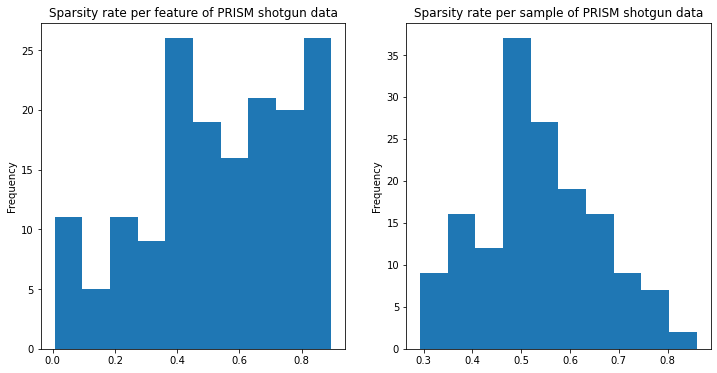

In [9]:
# fig, (ax1, ax2, ax3, ax) = plt.subplots(nrows=1, ncols= 3,figsize=(16,6))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols= 2,figsize=(12,6))

# Plot sparsity per feature/Sample of new datasets
# PRISM
zeros = data_profiling_tools.get_spartsity_plot(stgndf_PRISM, should_plot=False)
zeros.plot(kind='hist', ax=ax1)
ax1.set_title('Sparsity rate per feature of PRISM shotgun data')

zeros = data_profiling_tools.get_spartsity_plot(stgndf_PRISM, _ax=1 ,should_plot=False)
zeros.plot(kind='hist', ax=ax2)
ax2.set_title('Sparsity rate per sample of PRISM shotgun data')


plt.show()




### Metabolomics data


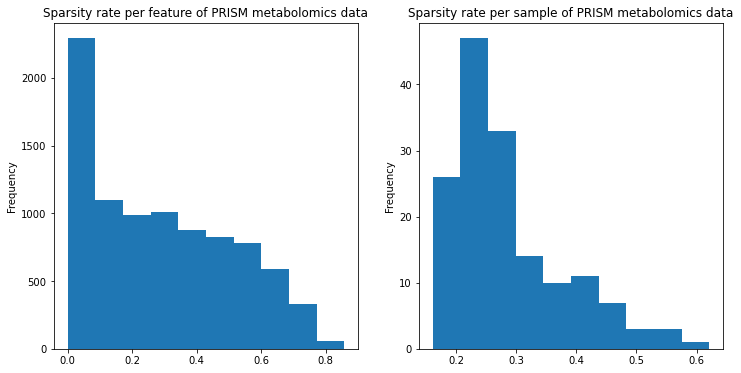

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols= 2,figsize=(12,6))

# Plot sparsity per feature/Sample of new datasets
# PRISM
zeros = data_profiling_tools.get_spartsity_plot(mbdf_PRISM, should_plot=False)
zeros.plot(kind='hist', ax=ax1)
ax1.set_title('Sparsity rate per feature of PRISM metabolomics data')

zeros = data_profiling_tools.get_spartsity_plot(mbdf_PRISM, _ax=1 ,should_plot=False)
zeros.plot(kind='hist', ax=ax2)
ax2.set_title('Sparsity rate per sample of PRISM metabolomics data')


plt.show()




# Generate folds

In [11]:
Y = stgndf_PRISM.copy()
X = mbdf_PRISM.copy()
K = 20
X = X.loc[X.index.intersection(Y.index)]
Y = Y.loc[X.index.intersection(Y.index)]

In [12]:
reload(predict_species)

<module 'predict_species' from '/Users/d_private/PycharmProjects/mat_imputation_demo/predict_species.py'>

In [22]:
path

'/Users/d_private/OneDrive - mail.tau.ac.il/Lab/data/FRANZOSA_IBD_2019'

In [23]:
# (path_to_X, path_to_Y, path_to_folds_dict, curr_fold_num)/

In [66]:
from os import path
import os
#TODO - Needs finishing
out_path = '/Users/d_private/PycharmProjects/mat_imputation_demo/condor_scripts'

def generate_parmas_file(path_to_X, path_to_Y, path_to_dict, out_path, file_name, num_jobs):
    os.makedirs(out_path, exist_ok=True)
    filename = f'{out_path}/{file_name}.txt'
    lines = []
    with open(filename, mode='w+') as file:
        for i in range(1, num_jobs+1):
            job_params = [f'{path_to_X}', f"{path_to_Y}", f"{path_to_dict}", str(i)]
            
            job_params_string = ", ".join(job_params)
            file.write(f'{job_params_string}\n')
#             lines.append(job_params_string)
            
    #         print(job_params_string)

#         file.writelines(lines, )
    return filename

# parmas_file_path = generate_parmas_file(path)

In [67]:

base = 'FRANSOZA_IBD_2019/PARSED_DATA'
parmas_file_path = generate_parmas_file(path_to_X = f'{base}/basic_process_reduce_sparse/mbdf_PRISM_reduced_sparse.csv',
                                        path_to_Y = f'{base}/basic_process_reduce_sparse/stgndf_PRISM_reduced_sparse.csv',
                                        path_to_dict = f'{base}/folds_240521',
                                        out_path = '/Users/d_private/PycharmProjects/mat_imputation_demo/condor_scripts',
                                        file_name='distributed_RF_params.txt',
                                        num_jobs = len(folds_dict)
                                       )


# Implement KFold / COOV and preform basic analysis

In [13]:
# from predict_species import generate_folds, init_fold_job, local_pipe, read_fold_dict
import Transformer
import predict_species
import ignore_Y_zeros_transformer

In [14]:
stgndf_PRISM = pd.read_csv(f'{data_path}/stgndf_PRISM_reduced_sparse.csv', index_col = '# Sample / Feature')
mbdf_PRISM = pd.read_csv(f'{data_path}/mbdf_PRISM_reduced_sparse.csv', index_col = '# Sample / Feature')

out_ =  f'{path}/PARSED_DATA/folds_240521'

path_to_Y = f'{data_path}/stgndf_PRISM_reduced_sparse.csv'
path_to_X = f'{data_path}/mbdf_PRISM_reduced_sparse.csv'



In [15]:
K = 20
# path_to_dict, folds_dict = predict_species.generate_folds(X, '/Users/d_private/OneDrive - mail.tau.ac.il/Lab/data/FRANZOSA_IBD_2019/PARSED_DATA/folds_240521', K, False)
path_to_dict = '/Users/d_private/OneDrive - mail.tau.ac.il/Lab/data/FRANZOSA_IBD_2019/PARSED_DATA/folds_240521/folds_dict.json'




In [19]:
# Include zeros and log transform
# rmse_df, preds_dict = local_pipe(X, Y, path_to_dict)

# Ignore zeros of y, don't log transform
reload(predict_species)
ignore_zeros_transformer = ignore_Y_zeros_transformer.get_transformer()
preds_dict, rmse_df  = predict_species.local_pipe(X, Y, path_to_dict, ignore_zeros_transformer)

<Logger predict_species (WARNING)>
Starting fold 1.
(154, 164)
Methanobrevibacter_smithii
Rothia_mucilaginosa
Propionibacterium_freudenreichii
19
Finished fold 1.
<Logger predict_species (WARNING)>
Starting fold 2.
(154, 164)
Methanobrevibacter_smithii
Rothia_mucilaginosa
Propionibacterium_freudenreichii
18
Finished fold 2.
<Logger predict_species (WARNING)>
Starting fold 3.
(154, 164)
Methanobrevibacter_smithii
Rothia_mucilaginosa
Propionibacterium_freudenreichii
21
Finished fold 3.
<Logger predict_species (WARNING)>
Starting fold 4.
(154, 164)
Methanobrevibacter_smithii
Rothia_mucilaginosa
Propionibacterium_freudenreichii
19
Finished fold 4.
<Logger predict_species (WARNING)>
Starting fold 5.
(154, 164)
Methanobrevibacter_smithii
Rothia_mucilaginosa
Propionibacterium_freudenreichii
19
Finished fold 5.
<Logger predict_species (WARNING)>
Starting fold 6.
(154, 164)
Methanobrevibacter_smithii
Rothia_mucilaginosa
Propionibacterium_freudenreichii
22
Finished fold 6.
<Logger predict_specie

## Write down results of CV

In [13]:
out_path = '/Users/d_private/OneDrive - mail.tau.ac.il/Lab/data/FRANZOSA_IBD_2019/PARSED_DATA/preds 310521'
rmse_df.to_csv(f'{out_path}/rmse_{K}fold_cv_transformed.csv' )
for fold, preds in preds_dict.items():
    preds.to_csv(f'{out_path}/{fold}_preds.csv')

# Analyze CV results

In [157]:
reload(predict_species)

<module 'predict_species' from '/Users/d_private/PycharmProjects/mat_imputation_demo/predict_species.py'>

In [158]:

# from sklearn.ensemble import RandomForestRegressor as RF

# mod = RF(n_jobs = -1)

# folds_dict = predict_species.read_fold_dict(path_to_dict)

# preds, rmse = predict_species.handle_single_fold(X, Y, folds_dict, 1, mod, ignore_zeros_transformer)

<Logger predict_species (WARNING)>
Starting fold 1.
(154, 164)
Methanobrevibacter_smithii
Rothia_mucilaginosa
Propionibacterium_freudenreichii
Bifidobacterium_adolescentis
Bifidobacterium_animalis
Bifidobacterium_bifidum
Bifidobacterium_breve
Bifidobacterium_catenulatum
Bifidobacterium_dentium
Bifidobacterium_longum
0
Finished fold 1.



## Read results of CV

In [12]:
import glob
rmse_df = pd.read_csv(f'{out_path}/rmse_{K}fold_cv_transformed.csv', index_col = 0)
preds_dict = {filename.split('/')[-1].split('_preds')[0] : pd.read_csv(filename, index_col =0) for filename in glob.glob(f'{out_path}/fold_*')}

In [20]:
# preds_dict = {key : preds_df.iloc[val['ts_idx'],:] for (key, val) in folds_dict.items()}

## Renormalize predictions to sum up to 1

In [13]:
from sklearn.preprocessing import normalize

def normalize_preds_dict(preds_dict):
    preds_dict_normalized = {}
    for fold, df in preds_dict.items():
        res = df.copy()
        res[df.columns] = normalize(df, axis = 1, norm='l1')
        preds_dict_normalized[fold] = res
    
    return preds_dict_normalized

In [14]:
preds_dict_normalized = normalize_preds_dict(preds_dict)
preds_dict_normalized

{'fold_5':                     Methanobrevibacter_smithii  Rothia_mucilaginosa  \
 # Sample / Feature                                                    
 PRISM|7879                            0.004083             0.008646   
 PRISM|7897                            0.006350             0.007952   
 PRISM|7899                            0.006212             0.008572   
 PRISM|7904                            0.006473             0.008195   
 PRISM|7906                            0.006613             0.007846   
 PRISM|7908                            0.006919             0.008325   
 PRISM|7909                            0.005343             0.008454   
 PRISM|7910                            0.006320             0.008278   
 
                     Propionibacterium_freudenreichii  \
 # Sample / Feature                                     
 PRISM|7879                                  0.007216   
 PRISM|7897                                  0.007181   
 PRISM|7899                             

## build ranks vector for each fold

In [259]:
def abundance_rank_per_fold(preds_dict, ascending_flag = True):
    
    preds_dict_abundance_ranks = {}
    for fold, df in preds_dict.items():
        res = df.copy()
        res[df.columns] = res.rank(axis = 1, ascending = ascending_flag)

        preds_dict_abundance_ranks[fold] = res
    
    return preds_dict_abundance_ranks
    

In [260]:
preds_dict_ranks = abundance_rank_per_fold(preds_dict_normalized)
# preds_dict_ranks['fold_1']

In [61]:
preds_dict_ranks['fold_1'].mean(axis = 0).rank().astype(int)

Methanobrevibacter_smithii           32
Rothia_mucilaginosa                 160
Propionibacterium_freudenreichii    111
Bifidobacterium_adolescentis         40
Bifidobacterium_animalis            151
                                   ... 
Escherichia_unclassified             46
Klebsiella_pneumoniae                83
Klebsiella_unclassified             132
Haemophilus_parainfluenzae          117
Akkermansia_muciniphila              35
Length: 164, dtype: int64

In [38]:
folds_dict = predict_species.read_fold_dict('/Users/d_private/OneDrive - mail.tau.ac.il/Lab/data/FRANZOSA_IBD_2019/PARSED_DATA/folds_240521/folds_dict.json')
# folds_dict


### Create mean rank vector for each specie in each fold

In [146]:
# TODO - Change this to a single fold and create another wrapper for while dataset
def get_mean_rank_vector_per_fold(preds_dict):
    
    ranks_dict = {}
    for fold, df in preds_dict.items():
        ranks_dict[fold] = df.mean(axis = 0).rank()

    
    return ranks_dict



In [35]:
summarized_ranks_dict_per_fold = get_mean_rank_vector_per_fold(preds_dict_ranks)
summarized_ranks_dict_per_fold

{'fold_5': Methanobrevibacter_smithii           77
 Rothia_mucilaginosa                 153
 Propionibacterium_freudenreichii    119
 Bifidobacterium_adolescentis         42
 Bifidobacterium_animalis            131
                                    ... 
 Escherichia_unclassified             99
 Klebsiella_pneumoniae               110
 Klebsiella_unclassified             138
 Haemophilus_parainfluenzae          112
 Akkermansia_muciniphila              39
 Length: 164, dtype: int64,
 'fold_17': Methanobrevibacter_smithii           94
 Rothia_mucilaginosa                 127
 Propionibacterium_freudenreichii    103
 Bifidobacterium_adolescentis         37
 Bifidobacterium_animalis            139
                                    ... 
 Escherichia_unclassified             23
 Klebsiella_pneumoniae                44
 Klebsiella_unclassified              92
 Haemophilus_parainfluenzae           64
 Akkermansia_muciniphila              47
 Length: 164, dtype: int64,
 'fold_13': Methanobr

### Compare each folds summarized predicted ranks to it's actual ranks

In [239]:
obs_fold_dict['fold_1']['Bifidobacterium_longum']

# Sample / Feature
PRISM|7122    0.000042
PRISM|7147    0.000074
PRISM|7150    0.100955
PRISM|7153    0.000028
PRISM|7184    0.000098
PRISM|7238    0.161830
PRISM|7406    0.000129
PRISM|7408    0.000059
Name: Bifidobacterium_longum, dtype: float64

In [153]:
obs_fold_dict = {fold : Y.iloc[val['ts_idx'],:] for fold, val in folds_dict.items()}
obs_dict_ranks = abundance_rank_per_fold(obs_fold_dict, False)
obs_summarized_ranks_dict_per_fold = get_mean_rank_vector_per_fold(obs_dict_ranks)
obs_summarized_ranks_dict_per_fold

non_zeros_obs_dict = {fold : val[val != 0] for fold, val in obs_fold_dict.items()}
obs_dict_ranks_non_zeros = abundance_rank_per_fold(non_zeros_obs_dict, False)
obs_summarized_ranks_dict_per_fold_non_zeros = get_mean_rank_vector_per_fold(obs_dict_ranks_non_zeros)


7

In [254]:
NUM_BINS = 4
corrs_dict = {}
corrs_dict_zeros_included = {}
corrs_dict_inter_observed = {}
corrs_rmse_to_rank = {}

fold_data_dict = {}


# labels=['High abundance', 'Med abundance', 'Low abundance']
labels=[f'bin_{i}' for i in range(1, NUM_BINS+1)]


for fold in folds_dict.keys():
    fold_obs_rank = obs_summarized_ranks_dict_per_fold[fold]
    fold_preds_rank = summarized_ranks_dict_per_fold[fold]
    fold_obs_rank_non_zeros = obs_summarized_ranks_dict_per_fold_non_zeros[fold]
    fold_rmse = rmse_df[fold]
    
    fold_data = pd.DataFrame(data = zip(fold_preds_rank, folds_obs_rank_non_zeros, fold_obs_rank, fold_rmse),
                             columns = ['pred_rank','obs_rank_non_zeros','obs_rank', 'rmse'], index = fold_preds_rank.index)
    fold_data['abundance_rank_bin'] = pd.cut(fold_data.obs_rank, NUM_BINS, labels=labels, duplicates='drop')
    fold_data.sort_values(by = 'obs_rank_non_zeros')
    fold_data_dict[fold] = fold_data
    
    # High rank = low abundance
    corrs_dict[fold] = fold_data.groupby('abundance_rank_bin').apply(lambda group: group.obs_rank_non_zeros.corr(group.pred_rank))
    corrs_dict_zeros_included[fold] = fold_data.groupby('abundance_rank_bin').apply(lambda group: group.obs_rank.corr(group.pred_rank))
    corrs_dict_inter_observed[fold] = fold_data.obs_rank.corr(fold_data.obs_rank_non_zeros)
    corrs_rmse_to_rank[fold] = fold_data.groupby('abundance_rank_bin').obs_rank.corr(fold_data.rmse)
#     corrs_rmse_to_rank[fold] = fold_data.groupby('abundance_rank_bin').obs_rank.corr(fold_data.rmse)
    
    
    


,Methanobrevibacter_smithii,Rothia_mucilaginosa,Propionibacterium_freudenreichii,Bifidobacterium_adolescentis,Bifidobacterium_animalis,Bifidobacterium_bifidum,Bifidobacterium_breve,Bifidobacterium_catenulatum,Bifidobacterium_dentium,Bifidobacterium_longum,...,Bilophila_unclassified,Bilophila_wadsworthia,Citrobacter_unclassified,Enterobacter_cloacae,Escherichia_coli,Escherichia_unclassified,Klebsiella_pneumoniae,Klebsiella_unclassified,Haemophilus_parainfluenzae,Akkermansia_muciniphila
# Sample / Feature,,,,,,,,,,,,,,,,,,,,,
PRISM|7122,0.000000,0.000000,0.000000,0.000092,0.000000,0.000000,0.000000,0.000000,0.000000,0.000042,...,0.000000,0.000000,0.000174,0.0,0.000279,0.000000,0.000000,0.000000,0.000006,0.004785
PRISM|7147,0.000019,0.000009,0.000000,0.000015,0.000002,0.000008,0.000000,0.000000,0.000000,0.000074,...,0.000114,0.000000,0.000000,0.0,0.000072,0.000049,0.000000,0.000034,0.000027,0.000033
PRISM|7150,0.000000,0.000000,0.001754,0.040328,0.000019,0.000030,0.000004,0.000176,0.000000,0.100955,...,0.000000,0.000000,0.000000,0.0,0.055806,0.001712,0.000025,0.000000,0.000000,0.024580
PRISM|7153,0.000000,0.000000,0.000000,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000028,...,0.000000,0.000000,0.000000,0.0,0.006650,0.001111,0.000000,0.000000,0.000016,0.000073
PRISM|7184,0.000000,0.000000,0.000000,0.000026,0.000000,0.000000,0.000000,0.000000,0.000000,0.000098,...,0.004465,0.001078,0.000000,0.0,0.000328,0.000304,0.000000,0.000000,0.000027,0.002130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PRISM|9033,0.004906,0.000000,0.000000,0.565125,0.000000,0.000000,0.000019,0.000000,0.000000,0.018659,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000086,0.000000,0.000000,0.000000,0.000036
PRISM|9074,0.000000,0.000000,0.000000,0.000071,0.014173,0.000000,0.000000,0.000000,0.101625,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000862,0.001075,0.000000,0.000000,0.000678,0.000000
PRISM|9079,0.000000,0.000000,0.000000,0.000014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000009,...,0.010009,0.000675,0.000000,0.0,0.000164,0.000315,0.000000,0.000000,0.000000,0.000000


In [255]:
fold_data

,pred_rank,obs_rank_non_zeros,obs_rank,rmse,abundance_rank_bin
Methanobrevibacter_smithii,94,17.0,120.0,1.126964,bin_4
Rothia_mucilaginosa,141,134.0,136.0,1.868988,bin_4
Propionibacterium_freudenreichii,115,93.5,130.5,1.428819,bin_4
Bifidobacterium_adolescentis,59,120.0,20.0,1.301787,bin_1
Bifidobacterium_animalis,139,14.5,119.0,1.596577,bin_4
...,...,...,...,...,...
Escherichia_unclassified,42,79.0,47.0,1.227782,bin_2
Klebsiella_pneumoniae,83,NaN,152.0,1.335289,bin_4
Klebsiella_unclassified,125,88.0,134.0,1.665241,bin_4
Haemophilus_parainfluenzae,90,110.0,57.0,1.325810,bin_2


## Adjusted spearman correlation

In [15]:
def folds_to_full_df(preds_dict):
    
    folds_list = [fold_preds for fold_preds in preds_dict.values()]
    return pd.concat(folds_list)




In [76]:
predicted_df = folds_to_full_df(preds_dict)

In [77]:
from sklearn.preprocessing import normalize
predicted_df = predicted_df.apply(lambda x: np.power(10, -x))

predicted_df[predicted_df.columns] = normalize(predicted_df, axis = 1, norm='l1')
predicted_df
#         res = df.copy()
#         res[df.columns] =/ normalize(df, axis = 1, norm='l1')
#         preds_dict_normalized[fold] = res

,Methanobrevibacter_smithii,Rothia_mucilaginosa,Propionibacterium_freudenreichii,Bifidobacterium_adolescentis,Bifidobacterium_animalis,Bifidobacterium_bifidum,Bifidobacterium_breve,Bifidobacterium_catenulatum,Bifidobacterium_dentium,Bifidobacterium_longum,...,Bilophila_unclassified,Bilophila_wadsworthia,Citrobacter_unclassified,Enterobacter_cloacae,Escherichia_coli,Escherichia_unclassified,Klebsiella_pneumoniae,Klebsiella_unclassified,Haemophilus_parainfluenzae,Akkermansia_muciniphila
# Sample / Feature,,,,,,,,,,,,,,,,,,,,,
PRISM|7879,0.004848,0.000003,0.000033,0.013534,0.000005,0.000011,0.000007,0.000020,0.000014,0.017223,...,0.005733,0.000200,0.000028,0.000007,0.000649,0.000062,0.000035,0.000012,0.000015,0.014284
PRISM|7897,0.000147,0.000011,0.000038,0.001064,0.000117,0.000009,0.000017,0.000036,0.000167,0.043680,...,0.005283,0.000091,0.000059,0.000035,0.000910,0.000039,0.000073,0.000016,0.000643,0.000263
PRISM|7899,0.000171,0.000004,0.000059,0.000621,0.000008,0.000014,0.000004,0.000033,0.000013,0.006234,...,0.005885,0.000155,0.000041,0.000010,0.001211,0.000093,0.000039,0.000015,0.000013,0.002178
PRISM|7904,0.000146,0.000009,0.000040,0.000702,0.000007,0.000020,0.000018,0.000036,0.000021,0.009414,...,0.000054,0.000016,0.000034,0.000025,0.000888,0.000148,0.000059,0.000018,0.000108,0.006812
PRISM|7906,0.000093,0.000012,0.000038,0.000988,0.000030,0.000009,0.000013,0.000031,0.000023,0.022009,...,0.000056,0.000016,0.000046,0.000014,0.001106,0.000083,0.000058,0.000035,0.000083,0.001214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PRISM|8447,0.000292,0.000005,0.000044,0.002018,0.000006,0.000015,0.000007,0.000024,0.000021,0.002280,...,0.004800,0.000066,0.000041,0.000014,0.001838,0.000249,0.000065,0.000030,0.000014,0.002378
PRISM|8452,0.000293,0.000249,0.000256,0.004290,0.000178,0.000421,0.000080,0.000154,0.004806,0.017060,...,0.000162,0.000043,0.000406,0.000158,0.056929,0.001198,0.000518,0.000345,0.007976,0.000624
PRISM|8458,0.000253,0.000003,0.000089,0.000327,0.000016,0.000030,0.000007,0.000032,0.000030,0.007416,...,0.008239,0.000108,0.000038,0.000012,0.002020,0.000469,0.000062,0.000015,0.000039,0.001411


In [70]:
normalized

NameError: name 'normalized' is not defined

###  Bins division by mean relative abundance (taking zeros into acount)

In [18]:
predicted_df.loc[:,'Methanobrevibacter_smithii']

# Sample / Feature
PRISM|7879    0.004083
PRISM|7897    0.006350
PRISM|7899    0.006212
PRISM|7904    0.006473
PRISM|7906    0.006613
                ...   
PRISM|8447    0.006005
PRISM|8452    0.006418
PRISM|8458    0.006179
PRISM|8462    0.006741
PRISM|8464    0.006891
Name: Methanobrevibacter_smithii, Length: 154, dtype: float64

In [78]:
Y[['Methanobrevibacter_smithii', 'Eubacterium_rectale']]

,Methanobrevibacter_smithii,Eubacterium_rectale
# Sample / Feature,,
PRISM|7122,0.000000,0.000343
PRISM|7147,0.000019,0.220046
PRISM|7150,0.000000,0.013998
PRISM|7153,0.000000,0.385641
PRISM|7184,0.000000,0.000242
...,...,...
PRISM|9033,0.004906,0.062764
PRISM|9074,0.000000,0.000043
PRISM|9079,0.000000,0.107093


In [79]:
predicted_df[['Methanobrevibacter_smithii', 'Eubacterium_rectale']]

,Methanobrevibacter_smithii,Eubacterium_rectale
# Sample / Feature,,
PRISM|7879,0.004848,0.085512
PRISM|7897,0.000147,0.045485
PRISM|7899,0.000171,0.108311
PRISM|7904,0.000146,0.103424
PRISM|7906,0.000093,0.071767
...,...,...
PRISM|8447,0.000292,0.038768
PRISM|8452,0.000293,0.015016
PRISM|8458,0.000253,0.022391


<AxesSubplot:>

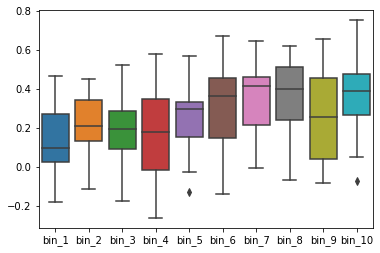

In [83]:
NUM_BINS = 10
labels=[f'bin_{i}' for i in range(1, NUM_BINS+1)]
bins = pd.qcut(Y.mean(axis = 0), q = NUM_BINS, labels = labels) # High bin = High abundance

corrs = {}
for col in Y.items():
#     print(col[1].head(5))
#     print(predicted_df.loc[:,col[0]].head(5))
#     print(bins[col[0]])
    _corr = col[1].corr(predicted_df.loc[:,col[0]], method='spearman') 
    corrs[col[0]] = _corr

corrs_series = pd.Series(corrs)



sns.boxplot(x = bins, y = corrs_series)

# plt.show()
# fold_cols = [col for col in list(rmse_df.columns) if col.startswith('fold')]
# rmse_df['mean_rmse'] = rmse_df[fold_cols].mean(axis = 1)

# sns.boxplot(data=rmse_df, x = bins, y = 'mean_rmse', )
# plt.show()

In [26]:

labels=[f'bin_{i}' for i in range(1, NUM_BINS+1)]
bins = pd.qcut(Y.mean(axis = 0), q = NUM_BINS, labels = labels)

rmse_df['abundance_rank_bin'] = bins
# rmse_df
# corrs = {}
# for col in Y.items():
#     _corr = col[1].corr(predicted_df.loc[:,col[0]], method='spearman') 
#     corrs[col[0]] = _corr

# corrs_series = pd.Series(corrs)

# sns.boxplot(x = bins, y = corrs_series)
# # High bin = High abundance
# bins

In [30]:
# rmse_df

# rmse_df[fold_cols].mean(axis = 1)
rmse_df



,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,fold_10,...,fold_13,fold_14,fold_15,fold_16,fold_17,fold_18,fold_19,fold_20,abundance_rank_bin,mean_rmse
Methanobrevibacter_smithii,0.991807,1.354046,1.095195,2.782870,1.342376,2.336086,1.685536,2.431639,2.024787,1.220775,...,1.186219,0.564031,2.149964,0.799513,0.581712,0.800093,1.239201,1.126964,bin_7,1.445188
Rothia_mucilaginosa,2.780808,2.675588,1.941234,3.807125,1.950432,3.335576,2.404350,3.026366,3.585689,2.430753,...,1.876538,1.461128,3.869833,1.741338,0.977600,0.920892,2.713003,1.868988,bin_1,2.417514
Propionibacterium_freudenreichii,1.851737,1.799333,1.329866,3.067992,1.459773,2.596576,1.851185,2.699552,2.755260,1.566609,...,1.251249,0.967687,3.064495,1.098654,0.701720,0.873032,1.971681,1.428819,bin_1,1.803419
Bifidobacterium_adolescentis,0.972343,1.262688,1.446556,2.554783,1.680634,2.050342,1.731745,1.499144,2.192170,1.245787,...,1.501055,1.120248,2.369422,1.627810,0.399945,0.960071,1.176600,1.301787,bin_10,1.489097
Bifidobacterium_animalis,2.533796,2.386493,1.584482,3.456876,1.600622,3.079828,2.092265,3.151170,3.341866,2.359597,...,1.690418,1.095955,3.817314,1.354408,1.101233,1.075735,2.178048,1.596577,bin_6,2.218621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Escherichia_unclassified,1.390901,1.256921,1.076457,2.709474,1.357172,1.890014,1.511452,2.102417,2.248290,1.219817,...,1.046380,1.341578,2.593173,0.915366,0.882552,1.026186,1.641609,1.227782,bin_8,1.516472
Klebsiella_pneumoniae,1.808498,1.628321,1.171932,3.053525,1.347596,2.191716,1.654379,2.499717,2.719567,1.390692,...,1.244408,1.126674,3.070888,0.985833,0.676920,0.541801,1.713887,1.335289,bin_8,1.676433
Klebsiella_unclassified,2.195210,2.174626,1.610842,3.386578,1.656623,2.765127,1.881137,2.955040,3.116849,1.815707,...,1.429571,1.072559,3.391572,1.385670,0.564122,0.883548,2.123688,1.665241,bin_2,2.009773
Haemophilus_parainfluenzae,2.005497,1.907886,1.483860,2.801162,1.679079,2.568176,1.920567,2.697779,2.904737,1.743922,...,1.386219,0.997012,3.294042,1.116004,0.324146,0.972820,1.957172,1.325810,bin_8,1.832121


In [114]:
# We calculate the mean using only non-zero-samples in the original data
# mask = (preds_df != 0) 
preds_mean_abundance_per_specie = preds_df.apply(lambda col: col.dropna().mean(), axis = 'index')
preds_abundance_rank = mean_abundance_per_specie.rank().astype(int).sort_values()
preds_abundance_rank.name = "Predictions abundance rank"
# preds_abundance_rank

obs = Y.copy()
# mask = (obs != 0) 
obs_mean_abundance_per_specie = obs.apply(lambda col: col.dropna().mean(), axis = 'index')
obs_abundance_rank = obs_mean_abundance_per_specie.rank().astype(int).sort_values()
obs_abundance_rank.name = "Observed abundance rank"
# obs_abundance_rank

abundance_corrs = obs_abundance_rank.corr(preds_abundance_rank, method='spearman') 
abundance_corrs


NameError: name 'preds_df' is not defined

In [91]:
for specie in Y[Y!=0].items():
    
    print(len(specie[1]), len(specie[1].dropna()))

154 21
154 55
154 17
154 145
154 56
154 56
154 41
154 16
154 31
154 148
154 24
154 90
154 98
154 19
154 92
154 124
154 81
154 99
154 69
154 121
154 23
154 45
154 49
154 66
154 62
154 136
154 86
154 105
154 126
154 147
154 79
154 48
154 48
154 41
154 93
154 85
154 64
154 66
154 65
154 40
154 94
154 90
154 34
154 67
154 17
154 41
154 67
154 29
154 35
154 56
154 17
154 30
154 27
154 16
154 19
154 21
154 86
154 71
154 49
154 143
154 148
154 76
154 137
154 83
154 26
154 52
154 84
154 123
154 93
154 89
154 91
154 71
154 22
154 69
154 18
154 90
154 85
154 112
154 94
154 114
154 71
154 153
154 74
154 67
154 57
154 35
154 107
154 41
154 27
154 49
154 80
154 143
154 143
154 150
154 60
154 90
154 89
154 113
154 33
154 75
154 78
154 90
154 102
154 60
154 50
154 70
154 119
154 41
154 105
154 43
154 64
154 74
154 112
154 94
154 56
154 16
154 21
154 116
154 96
154 70
154 57
154 61
154 152
154 76
154 93
154 22
154 71
154 99
154 36
154 152
154 104
154 71
154 89
154 83
154 36
154 30
154 91
154 16
154 30

In [124]:
preds_abundance_rank.name = "Predictions abundance rank"


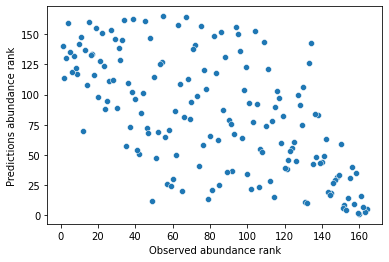

In [127]:
sns.scatterplot(x = obs_abundance_rank, y = preds_abundance_rank)
plt.show()

In [108]:
obs


,Methanobrevibacter_smithii,Rothia_mucilaginosa,Propionibacterium_freudenreichii,Bifidobacterium_adolescentis,Bifidobacterium_animalis,Bifidobacterium_bifidum,Bifidobacterium_breve,Bifidobacterium_catenulatum,Bifidobacterium_dentium,Bifidobacterium_longum,...,Citrobacter_unclassified,Enterobacter_cloacae,Escherichia_coli,Escherichia_unclassified,Klebsiella_pneumoniae,Klebsiella_unclassified,Haemophilus_parainfluenzae,Akkermansia_muciniphila,mean_abundance,abundance_rank
# Sample / Feature,,,,,,,,,,,,,,,,,,,,,
PRISM|8502,0.000000,0.000000,0.000000,0.000437,0.012278,0.000000,0.000000,0.000000,0.046184,0.000000,...,0.000000,0.000000,0.543184,0.057474,0.000000,0.000000,0.002583,0.000000,0.043150,154
PRISM|8452,0.000000,0.003712,0.000000,0.001636,0.000000,0.000000,0.000000,0.000000,0.000000,0.002932,...,0.000000,0.000000,0.001947,0.017778,0.000000,0.000000,0.000000,0.004210,0.030390,153
PRISM|7875,0.000000,0.000000,0.000000,0.003246,0.000000,0.000000,0.000000,0.000000,0.000000,0.030952,...,0.000000,0.000000,0.007378,0.000000,0.000000,0.000000,0.000000,0.002925,0.029985,152
PRISM|8336,0.000000,0.000254,0.000000,0.000030,0.000000,0.000000,0.000000,0.000000,0.000000,0.000028,...,0.000077,0.000004,0.000085,0.000084,0.000000,0.000000,0.000002,0.000020,0.028536,151
PRISM|8932,0.000000,0.000178,0.000000,0.000030,0.000000,0.000000,0.000000,0.000000,0.030186,0.040420,...,0.000000,0.000000,0.050012,0.002430,0.000050,0.000000,0.000411,0.000000,0.026500,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PRISM|8728,0.038135,0.000002,0.000000,0.039042,0.000003,0.000003,0.000003,0.001518,0.000000,0.000919,...,0.000000,0.000000,0.000071,0.000040,0.000000,0.000011,0.000002,0.000031,0.007984,5
PRISM|8754,0.000000,0.000054,0.000073,0.023724,0.000037,0.000009,0.000004,0.000435,0.000000,0.008511,...,0.000000,0.000000,0.000283,0.000000,0.000000,0.000000,0.000054,0.001670,0.007556,4
PRISM|8275,0.000000,0.000000,0.000000,0.000029,0.000032,0.064299,0.000015,0.000000,0.000000,0.089485,...,0.000000,0.000000,0.004518,0.000000,0.000104,0.000000,0.000000,0.001546,0.007406,3


In [96]:
obs = Y

(154, 164)

In [95]:
preds_df.shape

(154, 164)

In [ ]:
# rmse_df = pd.DataFrame.from_dict(rmse_dict)
rmse_df.to_csv(f'{out_path}/rmse_{NUM_FOLDS}fold_cv_transformed.csv' )
rmse_df.head(10)

# Visualize prediction results 

Categorize data by mean relative abundance of the species and the group the results according to this and plot the mean RMSE for each bin.


In [116]:
rmse_df = pd.read_csv(f'{out_path}/rmse_30fold_cv_transformed.csv', index_col = 0)

In [109]:
rmse_df

,Unnamed: 0,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,...,fold_12,fold_13,fold_14,fold_15,fold_16,fold_17,fold_18,fold_19,fold_20,mean_abundance
0,Methanobrevibacter_smithii,0.005629,0.010577,0.003464,0.090920,0.015625,0.216708,0.064381,0.062617,0.210766,...,0.007853,0.011807,0.003917,0.085658,0.009328,0.000106,0.001475,0.014789,0.015249,NaN
1,Rothia_mucilaginosa,0.008878,0.015008,0.005591,0.096634,0.013373,0.216998,0.064534,0.065038,0.222082,...,0.009695,0.006914,0.000672,0.092753,0.003578,0.000271,0.000565,0.017492,0.016542,NaN
2,Propionibacterium_freudenreichii,0.008780,0.015006,0.005453,0.096468,0.013241,0.216982,0.064548,0.065052,0.222028,...,0.009479,0.006929,0.000708,0.092680,0.003577,0.000062,0.000966,0.017446,0.016411,NaN
3,Bifidobacterium_adolescentis,0.035846,0.036764,0.099168,0.084558,0.034115,0.219058,0.039105,0.053617,0.193458,...,0.045491,0.047210,0.042830,0.073175,0.119725,0.014244,0.037704,0.016792,0.020036,NaN
4,Bifidobacterium_animalis,0.013958,0.014986,0.006350,0.093881,0.013278,0.216542,0.065133,0.065451,0.220787,...,0.010448,0.008393,0.008962,0.092086,0.005032,0.024328,0.003299,0.019245,0.016937,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,Escherichia_unclassified,0.014249,0.015034,0.007884,0.093751,0.012466,0.213661,0.061114,0.063272,0.221048,...,0.015230,0.009539,0.019992,0.091523,0.003640,0.010207,0.013103,0.019696,0.014690,NaN
160,Klebsiella_pneumoniae,0.040174,0.018081,0.006200,0.091556,0.012833,0.216062,0.063297,0.063361,0.221299,...,0.005479,0.009715,0.008184,0.090337,0.019728,0.037624,0.026012,0.026181,0.025145,NaN
161,Klebsiella_unclassified,0.009023,0.014984,0.005675,0.096612,0.013388,0.216919,0.064280,0.064936,0.222003,...,0.009716,0.006976,0.001651,0.092122,0.003333,0.001332,0.001666,0.017526,0.016417,NaN
162,Haemophilus_parainfluenzae,0.012266,0.018454,0.005953,0.096141,0.011584,0.214597,0.064590,0.066122,0.222149,...,0.015762,0.009941,0.016629,0.092334,0.004088,0.021566,0.008811,0.019746,0.011919,NaN


In [107]:
fold_cols

['fold_1',
 'fold_2',
 'fold_3',
 'fold_4',
 'fold_5',
 'fold_6',
 'fold_7',
 'fold_8',
 'fold_9',
 'fold_10',
 'fold_11',
 'fold_12',
 'fold_13',
 'fold_14',
 'fold_15',
 'fold_16',
 'fold_17',
 'fold_18',
 'fold_19',
 'fold_20',
 'fold_21',
 'fold_22',
 'fold_23',
 'fold_24',
 'fold_25',
 'fold_26',
 'fold_27',
 'fold_28',
 'fold_29',
 'fold_30']

In [118]:
data

,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,fold_10,...,fold_23,fold_24,fold_25,fold_26,fold_27,fold_28,fold_29,fold_30,abundance_rank_bin,mean_specie_RMSE
Eubacterium_rectale,0.096440,0.085047,0.090244,0.098580,0.044544,0.111557,0.118333,0.092092,0.253715,0.071430,...,0.104260,0.108477,0.066846,0.068026,0.090200,0.100162,0.105068,0.072310,bin_5,0.099711
Ruminococcus_sp_5_1_39BFAA,0.043134,0.054180,0.045045,0.046100,0.079317,0.052871,0.047198,0.053652,0.258573,0.074777,...,0.101132,0.040224,0.021348,0.027838,0.033813,0.037523,0.030228,0.029585,bin_5,0.065824
Faecalibacterium_prausnitzii,0.045974,0.064553,0.085930,0.082192,0.061181,0.086326,0.064934,0.057842,0.257681,0.098736,...,0.073403,0.086345,0.043225,0.033856,0.081324,0.067775,0.082477,0.062650,bin_5,0.086952
Escherichia_coli,0.023226,0.048342,0.019729,0.057092,0.115785,0.032849,0.009826,0.026550,0.254624,0.045024,...,0.100116,0.036392,0.044286,0.074327,0.086857,0.058142,0.039539,0.044822,bin_5,0.071327
Ruminococcus_gnavus,0.064033,0.051560,0.021508,0.030971,0.097287,0.046358,0.016892,0.055398,0.249198,0.051450,...,0.098123,0.029958,0.112266,0.123619,0.041588,0.069226,0.041471,0.028703,bin_5,0.076912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Anaerotruncus_unclassified,0.010112,0.000285,0.018339,0.000210,0.123441,0.001362,0.016763,0.038276,0.271799,0.081631,...,0.101535,0.000460,0.004078,0.000715,0.000081,0.020491,0.000312,0.019541,bin_1,0.045798
Clostridiaceae_bacterium_JC118,0.010150,0.000297,0.018446,0.000224,0.123463,0.001286,0.016791,0.038112,0.271768,0.081620,...,0.102048,0.000188,0.004189,0.000587,0.000184,0.020671,0.000445,0.019526,bin_1,0.045857
Rothia_mucilaginosa,0.010247,0.000322,0.018470,0.000219,0.123583,0.001231,0.016861,0.038346,0.271809,0.081639,...,0.102108,0.000083,0.004246,0.000616,0.000256,0.020673,0.000455,0.019544,bin_1,0.045890
Erysipelotrichaceae_bacterium_2_2_44A,0.010238,0.000206,0.018320,0.000314,0.123470,0.001186,0.016722,0.038305,0.271692,0.081582,...,0.102082,0.000120,0.004258,0.000738,0.000309,0.020695,0.000432,0.019612,bin_1,0.045873


In [113]:
rmse_df = rmse_nt.copy()

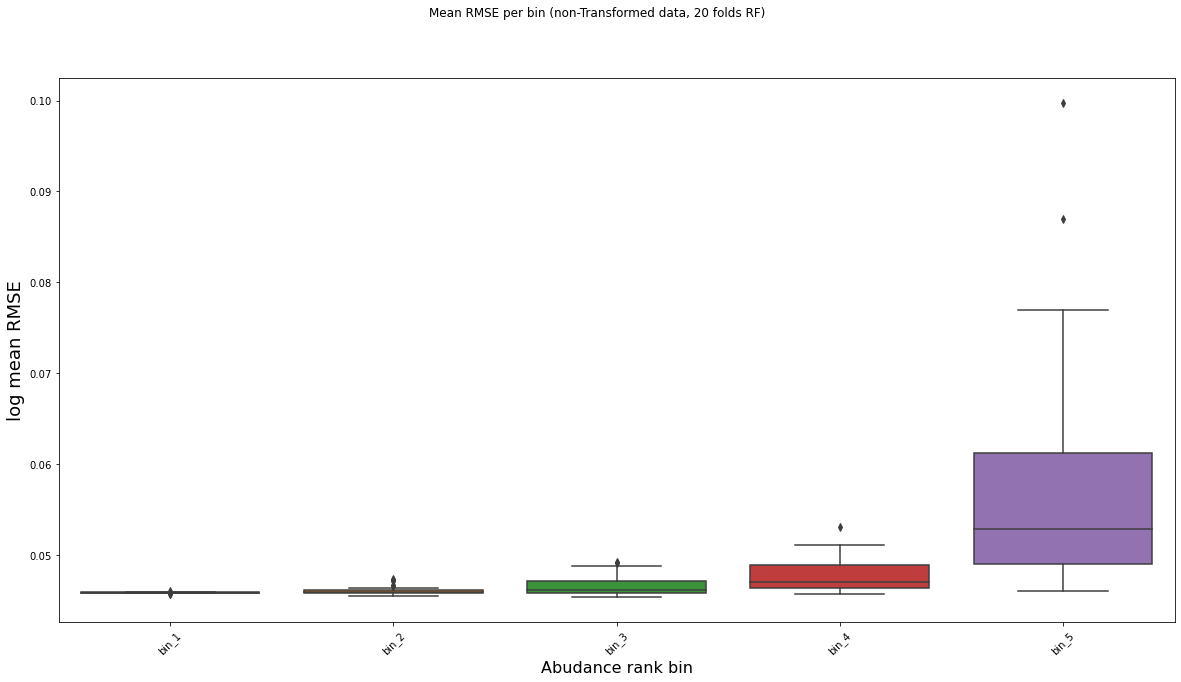

In [117]:
# Determine the number of bins for mean relative abundance
NUM_BINS = 5

# We calculate the mean using only non-zero-samples in the original data
mask = (Y != 0) 
rmse_df['mean_abundance'] = Y[mask].apply(lambda col: col.dropna().mean(), axis = 'index')
rmse_df = rmse_df.sort_values(by = 'mean_abundance', ascending=False)

# Map species to bins representing the rank of the mean relative abundance of the specie across samples
labels = [f'bin_{i}' for i in range(1, NUM_BINS+1)]
# labels = list(rmse_df.index.values)
rmse_df['abundance_rank_bin'] = pd.qcut(rmse_df.mean_abundance, q=NUM_BINS, labels = labels)
# rmse_df['abundance_rank_bin'] = pd.qcut(rmse_df.mean_abundance, q=NUM_BINS)
fold_cols = [col for col in list(rmse_df.columns) if col.startswith('fold')]
data = rmse_df.drop('mean_abundance', axis=1)
# data = rmse_df.copy()

# Add to each specie the mean rmse of the RF across all folds 
data['mean_specie_RMSE'] = data[fold_cols].apply(np.mean, axis =1)
# data.head()


fig = plt.figure(figsize=(20,10))

sns.boxplot(x='abundance_rank_bin', y='mean_specie_RMSE', data=data)
# plt.yscale('log')
fig.suptitle('Mean RMSE per bin (non-Transformed data, 20 folds RF) ',)
plt.xticks(rotation=45)
plt.ylabel('log mean RMSE', fontsize=18)
plt.xlabel('Abudance rank bin', fontsize=16)

plt.savefig(f'{out_path}/RMSE_vs_5_abundance_bins_20folds–nt.png')


# fig, axs = plt.subplots(2, 1, constrained_layout=True)
# axs[0].plot(t1, f(t1), 'o', t2, f(t2), '-')
# axs[0].set_title('subplot 1')
# axs[0].set_xlabel('distance (m)')
# axs[0].set_ylabel('Damped oscillation')
# fig.suptitle('This is a somewhat long figure title', fontsize=16)

# axs[1].plot(t3, np.cos(2*np.pi*t3), '--')
# axs[1].set_xlabel('time (s)')
# axs[1].set_title('subplot 2')
# axs[1].set_ylabel('Undamped')

In [96]:
out_path

'/Users/d_private/OneDrive - mail.tau.ac.il/Lab/data/FRANZOSA_IBD_2019/PARSED_DATA/scaleup_notebook'

In [110]:
rmse_nt = pd.read_csv('/Users/d_private/OneDrive - mail.tau.ac.il/Lab/data/FRANZOSA_IBD_2019/PARSED_DATA/scaleup_notebook/rmse_20fold_cv.csv', index_col=0)

## A good exmaple of why the results are the opposite of what we hoped for  

Samples that have low mean relative abundance are also usually very homogenic and so when predicting the a sample from the test data it highly resembles that train set which then leads to low RMSE.

In [ ]:
import preprocess_tools
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols= 2,figsize=(12,6))


df1 = preprocess_tools.impute_df_zeros_with_half_min(stgndf_PRISM[['Eubacterium_rectale', 'Streptococcus_sanguinis']])

df1.apply(lambda x: preprocess_tools.log_transform(x, True)).plot(kind='box', ax = ax2)
stgndf_PRISM[['Eubacterium_rectale', 'Streptococcus_sanguinis']].plot(kind='box', ax=ax1)
# stgndf_PRISM['Escherichia_unclassified']


# Correlations between the prediction error and the mean relative abundance rank



In [ ]:
rmse_df

In [ ]:

#         df_rmse['abundance_rank_bin'] = pd.qcut(df_rmse.mean_abundance, q=i, labels=range(1,i+1))

# rmse_by_bin = rmse_df.groupby('abundance_rank_bin')
# rmse_by_bin.boxplot(subplots=False, rot=45, column=fold_columns)
# boxplot = df.boxplot(by='X')

# ax[i-2].set_title(f'{i} bins, RMSE dist per bin by abundance, ')

df = pd.DataFrame(np.random.randn(10, 2),
                  columns=['Col1', 'Col2'])
df['X'] = pd.Series(['A', 'A', 'A', 'A', 'A',
                     'B', 'B', 'B', 'B', 'B'])
df.groupby('X').apply(np.mean, axis = 1).boxplot()
# df(

# Order the data by relative abundance level  

We order the data with respect to the mean relative abundance of each **Specie**

In [ ]:
'''
@param df_transformed: pd.DataFrame, row represent species (features). columns represent samples.
@param df_untransformed: pd.DataFrame, row represent species (features). columns represent samples, 
    this dataframe contains the original relative mean abundance data before zeros were replaced.

Calculate mean abundance per specie (row) while ignoring zeros
since we replaced the zeros before transforming we will use the original data to select and remove indexes that used to be zero.

'''
def get_mean_abundance_per_specie(df_untransformed: pd.DataFrame,  df_transformed: pd.DataFrame):
    df = df_transformed.copy().T
    mask = df_untransformed.T != 0 
    df['mean_abundance_post_trans'] = df[mask].apply(lambda row: row.dropna().mean(), axis = 'columns')
    df['mean_abundance_rank'] = df.mean_abundance_post_trans.rank()
    df = df.sort_values(by = 'mean_abundance_rank', ascending=False)

    
    return df

    

# Add mean relative abundance per specie and a rank based on it.    
tr_stgn_transofrmed_and_ordered = get_mean_abundance_per_specie(tr_stgn, tr_stgn_transformed.copy())
ts_stgn_transofrmed_and_ordered = get_mean_abundance_per_specie(ts_stgn, ts_stgn_transformed.copy())


'''
# Sanity check 
test = pd.DataFrame(data={'A':[2, 0, 0],
                  'B':[2,0,0],
                  'C':[1, 0, 0]})

display(test)
test_transformed = pd.DataFrame(data={'A':[100, 100, 100],
                  'B':[1,100,100],
                  'C':[2, 1, 1]})

get_mean_abundance_per_specie(test, test_transformed)
# '''


In [ ]:
df_rmse

In [ ]:
#
# Repeat the same method only by comparing the data when divided into 3 groups instead of 2:
import regex as re
MAX_NUM_BINS = 5



fig, ax = plt.subplots(nrows=1, ncols=4,figsize=(40,10))
# fig, ax = plt.subplots()

for i in range(2, MAX_NUM_BINS+1):
        
        
#         df_rmse['abundance_rank_bin'] = pd.qcut(df_rmse.mean_abundance, q=i, labels=range(1,i+1))
        rmse_df['abundance_rank_bin'] = pd.qcut(rmse_df.mean_abundance, q=i, labels=range(1,i+1))
        rmse_by_bin = rmse_df.groupby('abundance_rank_bin')
        rmse_by_bin.boxplot(subplots=False, ax=ax[i-2], rot=45, column=fold_columns)
        ax[i-2].set_title(f'{i} bins, RMSE dist per bin by abundance, ')

In [ ]:
mean_abundance

In [ ]:
# Write training, test datasets


tr_stgn_transofrmed_and_ordered.to_csv(f'{out_path}/tr_stgn_transofrmed_and_ordered.csv',
                       index=True, index_label="# Sample / Feature")
ts_stgn_transofrmed_and_ordered.to_csv(f'{out_path}/ts_stgn_transofrmed_and_ordered.csv', 
                       index=True, index_label="# Sample / Feature")
tr_mb_transformed.to_csv(f'{out_path}/tr_metabolome_transofrmed.csv', 
                         index=True, index_label="# Sample / Feature")
ts_mb_transformed.to_csv(f'{out_path}/ts_metabolome_transofrmed.csv',
                         index=True, index_label="# Sample / Feature")

# Test the predictability of high vs low abundancies by using RF & metabolites

Divide shotgun data into two groups. high vs low abundancy.
Use the metabolites data to train a RF model per each specie.
We then test the predictability of each group using the test ids.

In [ ]:

tr_stgn = pd.read_csv(f'{out_path}/tr_stgn_transofrmed_and_ordered.csv', index_col = '# Sample / Feature')
ts_stgn = pd.read_csv(f'{out_path}/ts_stgn_transofrmed_and_ordered.csv', index_col = '# Sample / Feature')
tr_mb = pd.read_csv(f'{out_path}/tr_metabolome_transofrmed.csv', index_col = '# Sample / Feature')
ts_mb = pd.read_csv(f'{out_path}/ts_metabolome_transofrmed.csv', index_col = '# Sample / Feature')

## Find main PCs of metabolome data 

We preform PCA to reduce dimensionality of metabolome data from a couple of thousands to 50

In [ ]:
from sklearn.decomposition import PCA

_X = tr_mb.copy()
_X_test = ts_mb.copy()
mod = PCA(n_components=20)
mod.fit(_X)

_X_pcs = mod.components_
_X_pcs.shape


_X_PCA = mod.transform(_X)
_X_test_PCA = mod.transform(_X_test)

mod.explained_variance_ratio_


## For each strain in shotgun data, try to predict it using metabolome data

In [ ]:
_X = tr_mb.copy()
_X_test = ts_mb.copy()

_Y = tr_stgn.drop(['mean_abundance_post_trans', 'mean_abundance_rank'], axis = 1)
_Y_test = ts_stgn.drop(['mean_abundance_post_trans', 'mean_abundance_rank'], axis = 1)

N_species = _Y.shape[0]

In [ ]:
_Y

In [ ]:
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.metrics import mean_squared_error as RMSE
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from collections import namedtuple
RMSEs = namedtuple('RMSEs', ['RF', 'Lasso', 'PCA', 'RF_PCA', 'Elastic'])

VERBOSE = True

mod = RF(n_jobs = -1)
lm_lasso = Lasso(max_iter = 2000)
lm_pca = LinearRegression()
lm_elastic = ElasticNet(max_iter = 2000)

rmse_dict = {}

# fig = plt.figure(figsize=(70,40))
# fig.subplots_adjust(hspace=0.4, wspace=0.4)


for i, (otu, row) in enumerate(list(_Y.iterrows())[:], 1):
    
    if VERBOSE:
        print(f"Now fitting rf regressor for specie: {otu}")

    _y = _Y.loc[otu,:]
    _y_test = _Y_test.loc[otu,:]
    

    # RF MODEL
        
    mod.fit(_X, _y)
        
    preds = pd.Series(data = mod.predict(_X_test), index = _y_test.index, name=f'Preds_RF')
    train_preds = pd.Series(data = mod.predict(_X), index = _y.index, name=f'Preds_RF')
    

    compare_df = pd.DataFrame(data = [_y_test, preds], dtype=np.float64).T
    compare_df.rename({f'{otu}':'observed'}, inplace = True, axis = 1)
    
    # Lasso
    
    if VERBOSE:
        print(f"Now fitting a lasso model for specie: {otu}")
    

    lm_lasso.fit(_X, _y)
    
    preds = pd.Series(data = lm_lasso.predict(_X_test), index = _y_test.index, name=f'Preds_LASSO')
    train_preds = pd.Series(data = lm_lasso.predict(_X), index = _y.index, name=f'Preds_LASSO')
    compare_df['Preds_Lasso'] = preds
    
    
    # PCA
    
    if VERBOSE:
        print(f"Now fitting a PCA regression model for specie: {otu}")
    
    lm_pca.fit(_X_PCA, _y)

    
    preds = pd.Series(data = lm_pca.predict(_X_test_PCA), index = _y_test.index, name=f'Preds_PCA')
    train_preds = pd.Series(data = lm_pca.predict(_X_PCA),index = _y.index, name=f'Preds_PCA')
    compare_df['Preds_PCA'] = preds

    
    # Reduced dimensionality RF
        
    mod.fit(_X_PCA, _y)
        
    preds = pd.Series(data = mod.predict(_X_test_PCA), index = _y_test.index, name=f'Preds_RF_PCA')
    train_preds = pd.Series(data = mod.predict(_X_PCA), index = _y.index, name=f'Preds_RF_PCA')
    compare_df['Preds_RF_PCA'] = preds
    
        
    # ElasticNet
        
    lm_elastic.fit(_X, _y)
        
    preds = pd.Series(data = lm_elastic.predict(_X_test), index = _y_test.index, name=f'Preds_Elastic')
    train_preds = pd.Series(data = lm_elastic.predict(_X), index = _y.index, name=f'Preds_Elastic')
    compare_df['Preds_Elastic'] = preds

    
    
    test_rmse_RF = round(RMSE(compare_df.observed, compare_df.Preds_RF, squared=False), 5)
    test_rmse_Lasso = round(RMSE(compare_df.observed, compare_df.Preds_Lasso, squared=False), 5)
    test_rmse_PCA = round(RMSE(compare_df.observed, compare_df.Preds_PCA, squared=False), 5)
    test_rmse_RF_PCA = round(RMSE(compare_df.observed, compare_df.Preds_RF_PCA, squared=False), 5)
    test_rmse_Elastic = round(RMSE(compare_df.observed, compare_df.Preds_Elastic, squared=False), 5)
    
    rmse_dict[otu] = RMSEs(test_rmse_RF, test_rmse_Lasso, test_rmse_PCA, test_rmse_RF_PCA, test_rmse_Elastic)
    
    if VERBOSE:
        print(f"test RMSE for RF: {test_rmse_RF}")
        print(f"test RMSE for Lasso: {test_rmse_Lasso}")
        print(f"test RMSE for PCA: {test_rmse_PCA}")
        print(f"test RMSE for RF PCA: {test_rmse_RF_PCA}")
        print(f"test RMSE for Elastic PCA: {test_rmse_Elastic}")
        
    print(f"Finished specie: {i}/{N_species}, Specie: {otu}")
        

print("Finished.")


# plt.savefig('RF_predictor_no_train.png')
# plt.show()


    

## Dig into the results

RF consistently prefroms better than Lasso therefore Lasso is omitted.

After fitting models: RF, Lasso for each specie from metabolites, we aggregate the RMSEs, and calculate the mean RMSE for each specie with respect to it's rank in the mean abundance criteria.

In [ ]:
df_rmse

In [ ]:
# df_rmse = pd.DataFrame.from_dict(rmse_dict, orient='index')

# mask = df_species.above_mean_abundance == True
# upper = df_rmse[mask].apply(np.mean, axis = 0)
# lower = df_rmse[~mask].apply(np.mean, axis = 0)

# print(f"Upper rmses:\n{upper}\n Lower rmses:\n{lower}")

# df_rmse = df_rmse.sort_values(by=['RF', 'Lasso', 'PCA', 'RF_PCA', 'Elastic'], ascending=True)
# df_rmse.to_csv(f'{out_path}/RMSEs_specie_from_metabs.csv')

Repeat the same methodology, we split the data into bins and plot rmses of each bin to identify which part of the data has the lowest RMSE.

## TODO
1. Verify the results
2. Iterate for multiple models

In [ ]:
pd.qcut(df_rmse.mean_abundance, q =2 )

In [ ]:
# Repeat the same method only by comparing the data when divided into 3 groups instead of 2:

MAX_NUM_BINS = 5

df_rmse = pd.DataFrame.from_dict(rmse_dict, orient='index')
df_rmse['mean_abundance'] = ts_stgn.mean_abundance_post_trans

fig, ax = plt.subplots(nrows=1, ncols=4,figsize=(40,10))
# fig, ax = plt.subplots()

for i in range(2, MAX_NUM_BINS+1):
    

#         df_rmse['abundance_rank_bin'] = pd.qcut(df_rmse.mean_abundance, q=i, labels=range(1,i+1))
        df_rmse['abundance_rank_bin'] = pd.qcut(df_rmse.mean_abundance, q=i, labels=range(1,i+1))
        rmse_by_bin = df_rmse.groupby('abundance_rank_bin')
        rmse_by_bin.boxplot(subplots=False, ax=ax[i-2], rot=45, column=['RF', 'Elastic'])
        ax[i-2].set_title(f'{i} bins, RMSE dist per bin by abundance, ')


plt.savefig(f'{out_path}/RMSEs_specie_from_metabs.png')
plt.show()


    

In [ ]:
print("RF: " , df_species.where(df_species.above_mean_abundance == False).test_rmse.mean())
print("Lasso: " , df_species.where(df_species.above_mean_abundance == False).test_rmse.mean())

In [ ]:
    # Top covariates
    pd.DataFrame(np.corrcoef(_y.to_numpy().astype(float), _X.to_numpy().astype(float), rowvar=False))
    # Find all correlations
    corr = np.corrcoef(_y.to_numpy().astype(float), df_metab.T.to_numpy().astype(float), rowvars=
    corr = pd.DataFrame(corr, 
                        columns = [otu] + list(mbdf_PRISM.index),
                        index = [otu] + list(mbdf_PRISM.index))
    
    # Step 4 - Filter out weak correlations 
    strong_corr = corr.loc[otu,:]
    strong_corr = strong_corr.where((strong_corr < .99) & (abs(strong_corr) > CORR_THRESHOLD)).dropna()
    strong_corr_dict[otu] = strong_corr
    strongest_corr_dict[otu] = strong_corr.where(abs(strong_corr) == abs(strong_corr).max()).dropna()
    
    # If no strong correlation was found, plot a infromative texst instead of a graph and skip the rest.
    if(len(strongest_corr_dict[otu]) == 0): 
        continue
        ax = fig.add_subplot(9, 8, i)
        ax.text(0.2, 0.4, f"{otu}:\n No strong correlations found", fontsize=12)

        
        
    # Prepare a unified dataframe with a column of the OTU relatvie abundances, Metabolites                 
    is_over_q20 = row > q_20
    df_full = pd.DataFrame(data = [row.replace(0, q_01/((row==0).sum()+1)), 
                                   mbdf_PRISM.loc[strongest_corr_dict[otu].index[0],:]])
    df_full = df_full.T    
        
            
    # Add Indicator columns for weather a samples is used or not (i.e it belongs to upper 80% or not.)
    df_full['is_over_q20'] = is_over_q20
    df_full['color']= np.where(is_over_q20==True , "#9b59b6", "#3498db")
    
    # Possible to back transform the data     
    # df_full[otu] = df_full[otu].apply(lambda x: -1*np.log(np.sin(x**2)))
    
    # Step 5 - Plotting



# TODO
Test for differential signal in each group
Test with 3 splits instead of 2



## Option 2 -  by median abundance 

In [ ]:
stgndf_PRISM.apply(lambda row: ((row==0).sum()/N_SAMPLES)*100, axis = 1).hist()

In [ ]:
((stgndf_PRISM.loc['Bacteroides_plebeius',:] == 0).sum())/N_SAMPLES

# Archieve

## Preprocess the data according to the paper
**From the subsection statistical analysis in the methods section of the paper:**  
* *Each data type was analysed separately in each cohort.*
* *Relative abundance values were log-transformed to variance-stabilize the data.*
* *Zero values were additively smoothed by half the smallest non-zero measurement on a per-sample basis.*
* *For both cohorts, we modelled the transformed abundance of each feature as a function of IBD phenotype (modelled as a categorical variable with ‘non-IBD control’ as the reference state), with age as a continuous covariate in both cohorts, and four medications (antibiotics, immunosuppressants, mesalamine and steroids) as binary covariates in the PRISM cohort.*


In [ ]:
stgndf_PRISM

In [ ]:
# temp = stgndf_PRISM.replace(0, np.nan)

min_abundance_per_sample = stgndf_PRISM.apply(lambda row: row.replace(0, np.nan).dropna().min())

In [ ]:
stgndf_PRISM = stgndf_PRISM.astype(float)
stgndf_PRISM_no_zeros = stgndf_PRISM.apply(lambda sample: sample.replace(0, min_abundance_per_sample[sample.name]/2))
stgndf_PRISM_processed = stgndf_PRISM_no_zeros.apply(lambda row: -1*np.log10(row))
# stgndf_PRISM.apply(lambda sample: sample.name)
# stgndf_PRISM_transformed = stgndf_PRISM.apply(lambda row: -np.log10(row))
 

In [ ]:
stgndf_PRISM_processed

## Extraction of important correlations between metabolites and bacteria
1. Find correlations in general
2. Filter weak correlations (e.g |corr| < .3) 
3. For each metabolite or specie create a dictionary with the specie or metabolies (opposite accordigly) that have strong correlation with it

In [ ]:
# 1. Find correlations between 16s and metabolites (correlations between rows based on shared columns)
# Since we'd like to use the non-zero center of the mass values to infer about the quantity of the lower values,
# we drop the zeros and then take the upper 80% of the data for each OTU. 
# Based on these upper 80% of each OTU we search for correlations in the metabolite data.

In [ ]:
# 2. we define a strong correlation as >.3 or <-.3 in the case of negative correlation
CORR_THRESHOLD = 0.3


In [ ]:
def is_var_specie(idx):
    return True if idx <= N_sxs else False

def extract_high_corrs(row, idx):
    coefs = {}
    if is_var_specie(idx):
        coefs = row[N_sxs+1:].dropna().to_dict()
        
    else:
        coefs = row[0:N_sxs].dropna().to_dict()
    
    return coefs

In [ ]:
# Constants 

VERBOSE = False
EPSILON = 0.01
CORR_THRESHOLD = 0.3


For each specie (column in stgndf_PRISM), we:  
1. construct a vector of non-zero samples.
2. Take the upper 80% percent of the vector (meaning the top 80% relative abundance counts of non zero samples)
3. Find the correlations between this samples and the same samples in the Metabolomic data (mbdf)
4. Filter Strong correlations only - Above <CORR_THRESHOLD> and store them in strong_corr_dict  
    a. If there are no such correlation we skip the rest
5. We then back plot the OTU and the Metabolites using one color for samples that were used in the process of finding the correlations and other color for samples that belong to the lower 20% or either are 0s.


In [ ]:

fig = plt.figure(figsize=(20,10))

fig.subplots_adjust(hspace=0.4, wspace=0.4)

strong_corr_dict = {}
strongest_corr_dict = {}

VERBOSE = True



for i, (otu, row) in enumerate(list(stgndf_PRISM_processed.iterrows())[:5], 1):
    
    print(otu)
    print(row)
    '''
    no_zeros = row.where(row > row.min())
    print(row.min)
    print(no_zeros)
    q_20 = no_zeros.quantile(.8)
    q_01 = no_zeros.quantile(.01)

    ra_over_q20 = no_zeros[no_zeros.map(lambda x: x > q_20)]
    
    if VERBOSE:
        print(f"For otu: {otu}, initial length is {len(row)}.\n"
              f"Number of zeros is: {row.apply(lambda val: val==0).sum()} "
              f"Number of values above 20 percentile: {len(ra_over_q20)}\n")
    
    # Step 3 - Find all correlations
    corr = np.corrcoef(ra_over_q20.to_numpy().astype(float), mbdf_PRISM[ra_over_q20.index].to_numpy().astype(float)) 
    corr = pd.DataFrame(corr, 
                        columns = [otu] + list(mbdf_PRISM.index),
                        index = [otu] + list(mbdf_PRISM.index))
    
    # Step 4 - Filter out weak correlations 
    strong_corr = corr.loc[otu,:]
    strong_corr = strong_corr.where((strong_corr < .99) & (abs(strong_corr) > CORR_THRESHOLD)).dropna()
    strong_corr_dict[otu] = strong_corr
    strongest_corr_dict[otu] = strong_corr.where(abs(strong_corr) == abs(strong_corr).max()).dropna()
    
    # If no strong correlation was found, plot a infromative texst instead of a graph and skip the rest.
    if(len(strongest_corr_dict[otu]) == 0): 
        continue
        ax = fig.add_subplot(9, 8, i)
        ax.text(0.2, 0.4, f"{otu}:\n No strong correlations found", fontsize=12)

        
        
    # Prepare a unified dataframe with a column of the OTU relatvie abundances, Metabolites                 
    is_over_q20 = row > q_20
    df_full = pd.DataFrame(data = [row.replace(0, q_01/((row==0).sum()+1)), 
                                   mbdf_PRISM.loc[strongest_corr_dict[otu].index[0],:]])
    df_full = df_full.T    
        
            
    # Add Indicator columns for weather a samples is used or not (i.e it belongs to upper 80% or not.)
    df_full['is_over_q20'] = is_over_q20
    df_full['color']= np.where(is_over_q20==True , "#9b59b6", "#3498db")
    
    # Possible to back transform the data     
    # df_full[otu] = df_full[otu].apply(lambda x: -1*np.log(np.sin(x**2)))
    
    # Step 5 - Plotting

    ax = fig.add_subplot(1, 5, i)
    ax.set_xlim([0, row.quantile(.95)])
#     i+=1

#     sns.regplot(x=otu, y=strongest_corr_dict[otu].index[0], data=df_full,
#                      scatter_kws={'facecolors': df_full.color}, fit_reg=True, logx=False,
#                 ax=ax)
    
    l1 = sns.regplot(x=otu, y=strongest_corr_dict[otu].index[0], data=df_full.loc[~df_full['is_over_q20']],
#                      scatter_kws={'facecolors': df_full.color},
            fit_reg=True, logx=False, ax=ax, truncate=False, label = 'Zeros and <q20')
    
    l2 = sns.regplot(x=otu, y=strongest_corr_dict[otu].index[0], data=df_full.loc[df_full['is_over_q20']],
                fit_reg=True, logx=False, ax=ax,  truncate=False, label = '>q20, Used'
    #                          scatter_kws={'facecolors': df_full.loc[df_full['is_over_q20']].color}
        )
    
    
    pearson_r = round(strongest_corr_dict[otu][0], 2)
    r_squared = round(pearson_r**2, 2)
#     txt = f"{otu.split(';')[1]} vs. {strongest_corr_dict[otu].index[0]},\n r: {pearson_r}, r^2: {r_squared}"    
    
#     ax.title.set_text(txt)
#     plt.show()


plt.savefig('corrs.png')
plt.show()


    




### Build an RF predictor and plot 

1. Tradtional train-test split 0.8:0.2

In [ ]:
from sklearn.model_selection import train_test_split

sxs_train, sxs_test = train_test_split(sxsdf.T, train_size = 0.8, test_size = 0.2, shuffle=True)
train_ids = sxs_train.T.columns.intersection(sample_ids)
test_ids = sxs_test.T.columns.intersection(sample_ids)


sxs_train, sxs_test = sxs_train.T, sxs_test.T
mb_train, mb_test = mbdf.loc[:,train_ids], mbdf.loc[:,test_ids]

After the train-test split we end up with the following dimensions:  
* Train - 192 samples  
* Test - 48 samples  


In [ ]:
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.metrics import mean_squared_error as RMSE

strong_corr_dict = {}
strongest_corr_dict = {}

VERBOSE = False

mod = RF(n_jobs = 8)
fig = plt.figure(figsize=(70,40))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, (otu, row) in enumerate(list(sxs_train.iterrows())[:-1], 1):
    
    if VERBOSE:
        print(f"Now building rf regressor for otu: {otu}")
    
    
    _y = row
    _X = mb_train.T
    
    _y_test_observed = sxs_test.loc[otu,:]
    _X_test = mb_test.T
    
    
        
    mod.fit(_X, _y)
        
    preds = pd.Series(data = mod.predict(_X_test), index = _y_test_observed.index, name=f'Preds')
    train_preds = pd.Series(data = mod.predict(_X), index = _y.index, name=f'Preds')
    
    
    compare_df = pd.DataFrame(data = [_y_test_observed, preds], dtype=np.float64).T
    compare_train_df = pd.DataFrame(data = [_y, train_preds], dtype=np.float64).T
    compare_train_df['is_train_data'] = True
    compare_df['is_train_data'] = False
    
    preds_vs_obs_df = pd.concat([compare_df, compare_train_df])
#     compare_df = compare_df.apply(lambda col: col.astype(np.float64), axis = 0)

    
    
    ax = fig.add_subplot(9, 8, i)
    no_zeros = row.replace(0, np.nan).dropna() # Just for calculating some xlim that is lower than 0 for visu
    ax.set_xlim([-no_zeros.quantile(.05), row.quantile(.95)])

    s1 = sns.scatterplot(x=otu, y=preds_vs_obs_df.Preds, 
                         data=preds_vs_obs_df.loc[~preds_vs_obs_df['is_train_data']], ax=ax)
#                      fit_reg=True, logx=False, ax=ax, truncate=False, label = 'Zeros and <q20')
    
#     s2 = sns.scatterplot(x=otu, y=preds_vs_obs_df.Preds,
#                          data=preds_vs_obs_df.loc[preds_vs_obs_df['is_train_data']], ax=ax)

#     l2 = sns.regplot(x=otu, y=compare_df.Preds, data=compare_df, ax=ax,
#                 fit_reg=True, logx=False,   truncate=False
#                          scatter_kws={'facecolors': df_full.loc[df_full['is_over_q20']].color})
    
    

    
    
    test_rmse = round(RMSE(_y_test_observed, preds, squared=False), 5)
    train_rmse = round(RMSE(_y, train_preds, squared=False), 5)
    ax.set_title(f'OTU: {otu}, RMSE test: {test_rmse}, train: {train_rmse}')

    if VERBOSE:
        print(f"Finished, test RMSE: {test_rmse}")
 


plt.savefig('RF_predictor_no_train.png')
plt.show()


    





2. Train-Test split based on the partitioning to zeros and non zeros.  We train on 80% of the non-zero values

In [ ]:

fig = plt.figure(figsize=(70,40))

fig.subplots_adjust(hspace=0.4, wspace=0.4)

strong_corr_dict = {}
strongest_corr_dict = {}

VERBOSE = True


mod = RF(n_jobs = 8)
for i, (otu, row) in enumerate(list(sxsdf.iterrows())[:-1], 1):
    
    #Step 1 - Split into train & test data where test data inclueds: all zeros and lower 20 percentiles of the non-zeros
    
    no_zeros = row.replace(0, np.nan).dropna()
    q_20 = no_zeros.quantile(.20)
    
    
    # y train is the ra (relative abundance) of the 80 upper percentile of non zero samples
    _y_train = no_zeros[no_zeros.map(lambda x: x >= q_20)]

    # X train is the metabolite features of the dervied samples that were chosen
    _X_train = mbdf[_y_train.index].T
    
    _y_test_observed = row[row.map(lambda x: x < q_20)]
    _X_test = mbdf[_y_test_observed.index].T
    

    if VERBOSE:
        print(f"For otu: {otu}, train size: {_X_train.shape[0]}, test size = {240-_X_train.shape[0]}\n"
              f"Number of zeros is: {row.apply(lambda val: val==0).sum()}\n"
              f"Number of values above 20 percentile: {len(ra_over_q20)}")
        
            
    mod.fit(_X_train, _y_train)
    
    
        
    preds = pd.Series(data = mod.predict(_X_test), index = _y_test_observed.index, name=f'Preds')
    train_preds = pd.Series(data = mod.predict(_X_train), index = _y_train.index, name=f'Preds')
    
    
    compare_df = pd.DataFrame(data = [_y_test_observed, preds], dtype=np.float64).T
    compare_train_df = pd.DataFrame(data = [_y_train, train_preds], dtype=np.float64).T
    compare_train_df['is_train_data'] = True
    compare_df['is_train_data'] = False
    preds_vs_obs_df = pd.concat([compare_df, compare_train_df])    
    
    ax = fig.add_subplot(9, 8, i)
    no_zeros = row.replace(0, np.nan).dropna() # Just for calculating some xlim that is lower than 0 for visu
    ax.set_xlim([-no_zeros.quantile(.05), row.quantile(.95)])
    ax.set_ylim([-no_zeros.quantile(.05), 1.2*preds.quantile(.99)])

    s1 = sns.scatterplot(x=otu, y=preds_vs_obs_df.Preds, 
                         data=preds_vs_obs_df.loc[~preds_vs_obs_df['is_train_data']], ax=ax)
    
    s2 = sns.scatterplot(x=otu, y=preds_vs_obs_df.Preds,
                     data=preds_vs_obs_df.loc[preds_vs_obs_df['is_train_data']], ax=ax)
    
    test_rmse = round(RMSE(_y_test_observed, preds, squared=False), 5)
    train_rmse = round(RMSE(_y_train, train_preds, squared=False), 5)
    ax.set_title(f'OTU: {otu}, RMSE test: {test_rmse}, train: {train_rmse}')

    if VERBOSE:
        print(f"Finished, RMSE test: {test_rmse}, train: {train_rmse}\n")


plt.savefig('RF_predict_zeros_based_division.png')
plt.show()


    




In [ ]:
df_full.is_over_q20.astype(int)

In [ ]:
otu

In [ ]:
df

In [ ]:
df.plot(kind = 'scatter', x = 'Actinobacteria;Collinsella', y='ARGININE')


In [ ]:
strongest_corr_dict

In [ ]:
strong_corr = corr.loc[otu,:]

In [ ]:
corr.loc[otu,:].where()

In [ ]:
len(corr.loc[otu,:].where((corr.loc[otu,:] < 1) & (abs(corr.loc[otu,:]) > CORR_THRESHOLD)).dropna())

In [ ]:
# For each metabolite and each specie we find the features that correlate with it while distinguishing 
# between mtabolites and species

strong_bacterical_coefs = {}
strong_metabolite_coefs = {}

for idx, (name, row) in enumerate(strong_corr.iloc[0:N_sxs,:].iterrows(), 1):
    strong_bacterical_coefs[name] = extract_high_corrs(row, idx)
#     print(f"Strong coeffs for {name}:")
#     print(strong_metabolite_coefs[name])
    
for idx, (name, row) in enumerate(strong_corr.iloc[N_sxs+1:,:].iterrows(), N_sxs+1):
    strong_metabolite_coefs[name] = extract_high_corrs(row, idx)
#     print(f"Strong coeffs for {name}:")
#     print(strong_metabolite_coefs[name])

In [ ]:

mbdf[ra_over_q20.index]

In [ ]:
A = sxs_train.astype(float).to_numpy()
B = mb_train.astype(float).to_numpy()

corr = pd.DataFrame(np.corrcoef(A, B), 
             columns = list(sxs_train.index) + list(mb_train.index),
            index = list(sxs_train.index) + list(mb_train.index))



In [ ]:
# For each metabolite and each specie we find the features that correlate with it while distinguishing 
# between mtabolites and species

strong_bacterical_coefs = {}
strong_metabolite_coefs = {}

for idx, (name, row) in enumerate(strong_corr.iloc[0:N_sxs,:].iterrows(), 1):
    strong_bacterical_coefs[name] = extract_high_corrs(row, idx)
#     print(f"Strong coeffs for {name}:")
#     print(strong_metabolite_coefs[name])
    
for idx, (name, row) in enumerate(strong_corr.iloc[N_sxs+1:,:].iterrows(), N_sxs+1):
    strong_metabolite_coefs[name] = extract_high_corrs(row, idx)
#     print(f"Strong coeffs for {name}:")
#     print(strong_metabolite_coefs[name])

    

In [ ]:
pd.DataFrame(strong_metabolite_coefs).dropna(how='all', axis = 'columns'
                                            ).isnull().agg({lambda row: sum(row)/len(row),
                                                           lambda row: len(row)-sum(row)}).T.mean(axis = 'index')


Most of the metabolites have around three strong correlations (pos or neg).

## Interpolation of zeros based on linear regression with variables from their correlation 
dict
Options:
1. regression based on correlation
2. PCA regression
3. Lasso
4. RF ?
5. kNN ? 


### Option 1 - regression based on correlation
This might be highly costly because we have to fit a regression for each line.


In [ ]:
describe_sparsity(mb_train)

In [ ]:
from sklearn.linear_model import LinearRegression
VERBOSE = False
X_train = mb_train.T
X_test = mb_test.T
for otu, coeffs in strong_bacterical_coefs.items():
    if(VERBOSE):
        print(f"Fitting a correlation based regression model for {otu}.")
    y_train = sxs_train.loc[otu,:]
    if (coeffs == {}):
        if(VERBOSE):
            print(f"No strong correlation were found for {otu}, regressing using all metabolites.")
        reg = LinearRegression().fit(X_train, y_train)
        preds = reg.predict(X_test)
    
    else:
        X_train_corr = X_train[coeffs]
        reg = LinearRegression().fit(X_train_corr, y_train)
        X_test_corr =  X_test[coeffs]
        preds = reg.predict(X_test_corr)
        


In [ ]:
print(otu)
pd.DataFrame({'preds':preds, 'true_labels':sxs_test.loc[otu,:]})


In [ ]:
# We now have a prediction vector for every bacteria based on it's correlated metabolites or in case there are non,
# then we predict using all metabolites. 
# Todo - gather all predictions to one dataframe and compare them to something.

### Option 2 - Lasso sparse regression
This might be highly costly because we have to fit a regression for each strain sepratley.


In [ ]:
from sklearn.linear_model import Lasso

VERBOSE = False
X_train = mb_train.T
X_test = mb_test.T
for otu, coeffs in strong_bacterical_coefs.items():
    if(VERBOSE):
        print(f"Fitting a correlation based regression model for {otu}.")
    y_train = sxs_train.loc[otu,:]
    
#     print(y_train)
    lm = Lasso()
#     lm.fit(X_train, y_train)
#     lm.fit([[.1, .02, -.0055], [.22, .000, -.7], [.5, .5, .5]], [.1,2.4, 10])
#     preds = lm.predict(X_test)
#     lm.predict([[.005, .4, .15]])

    if(VERBOSE):
        print(f"Coeffs for {otu}: {lm.coef_}")t
#     preds


In [ ]:
### Option 3 - PCA regression
This might be highly costly because we have to fit a regression for each strain seperatley.


In [ ]:
y_train.shape

In [ ]:
from sklearn.decomposition import PCA

VERBOSE = False
X_train = mb_train.T
X_test = mb_test.T

for otu, coeffs in strong_bacterical_coefs.items():
    y_train = sxs_train.loc[otu,:]

    if(VERBOSE):
        print(f"Decomposing train data for: {otu}.")
    mod = PCA(n_components=50)
    mod.fit(X_train)
    X_train_pca = mod.components_
    
    reg = LinearRegression().fit(X_train_pca, y_train)
#     X_test_pca = mod.transform(X_test)
    
    
    
    
#     y_train = sxs_train.loc[otu,:]
#     print(y_train)
#     lm = Lasso()
#     lm.fit(X_train, y_train)
#     lm.fit([[.1, .02, -.0055], [.22, .000, -.7], [.5, .5, .5]], [.1,2.4, 10])
#     preds = lm.predict(X_test)
#     lm.predict([[.005, .4, .15]])

#     if(VERBOSE):
#         print(f"Coeffs for {otu}: {lm.coef_}")t
#     preds

In [ ]:
X_train.shape
X_test.shape

In [ ]:
X_train = mb_train
X_test = mb_test

mod = PCA(n_components=40)
mod.fit(X_train)
X_train_pca = mod.components_
X_test_pca = mod.transform(X_test)

y_train = sxs_train.loc[otu,:]

# if(VERBOSE):
#     print(f"Decomposing train data for: {otu}.")




# reg = LinearRegression().fit(X_train_pca, y_train)

In [ ]:
X_train_pca.shape

In [ ]:
X_test_pca.shape

In [ ]:
mb_train.shape

In [ ]:
pd.DataFrame(X_train_pca)
# ≈.shape


In [ ]:
from sklearn.decomposition import PCA


mod = PCA(n_components=50)
mod.fit(mb_train.T)


# X_train = mb_train.T
# X_train.head()
# y_train = sxs_train.loc[otu,:]
# print(y_train)
# lm = Lasso()
# lm.fit(X_train, y_train)
# lm.coef_
# lm.predict(X_test)

In [ ]:
mb_train.T

print(otu)
pd.DataFrame({'preds':preds, 'true_labels':sxs_test.loc[otu,:]})


# Old blocks

### Create a subset of the data
Divide the data into 0.8:0.2 (samples) and apply this division to both the metabolites and the species

In [ ]:
from sklearn.model_selection import train_test_split

sxs_train, sxs_test = train_test_split(sxsdf.T, train_size = 0.8, test_size = 0.2, shuffle=True)
train_ids = sxs_train.T.columns.intersection(sample_ids)
test_ids = sxs_test.T.columns.intersection(sample_ids)


sxs_train, sxs_test = sxs_train.T, sxs_test.T
mb_train, mb_test = mbdf.loc[:,train_ids], mbdf.loc[:,test_ids]

In [ ]:
A.corrwith(B, drop=True, axis='columns')

In [ ]:
C = A.replace(0, np.nan)
C.corrwith(B, axis='columns')

In [ ]:
for ind1, specie in A.iterrows():
    for ind2, metabolite in B.iterrows():
        print(specie.corr(metabolite))
        print(ind2, ind1)
        

# s1 = A.iloc[0,:]
# s2 = B.iloc[0,:]
# s2.corr(s1)

# s1


In [ ]:
B

In [ ]:
# A.corrwith(B, axis = 'columns')
a0 = A.loc['Actinobacteria;Actinomyces',:]

In [ ]:
A.astype(float).corrwith(B.astype(float), axis = 'columns')

In [ ]:
a0

In [ ]:
s1

In [ ]:
# for row_name, row in B.iterrows():
#     print(row[1])
#     row.corr(A.loc['Actinobacteria;Actinomyces',:])
#     print(row.corr(a0.values))
# .2, .0, .6, .2
    
s1 = pd.Series({'H001':.2, 'H002':0.0, 'H003':0.6, 'H004':0.2})
s2 = pd.Series([-0.116793,-0.382685, 0.019573, 0.202570])
s1.corr(a0.astype(float))

In [36]:
data_path


'/Users/d_private/OneDrive - mail.tau.ac.il/Lab/data/FRANZOSA_IBD_2019/PARSED_DATA/basic_process_reduce_sparse'

In [ ]:
A.astype(float)


In [ ]:
feat_wgs_df = pd.read_csv(f'{data_path}/WGS/taxonomic_profiles.tsv', sep='\t', header = 0, index_col=0)
# Drop everything but specie levels
print(feat_wgs_df.shape)
mask = feat_wgs_df.index.str.contains("s__") & (feat_wgs_df.index.str.contains("t__") == False)
feat_wgs_filtered = feat_wgs_df.drop(feat_wgs_df[~mask].index.values, inplace=False)
print(feat_wgs_filtered.shape)

In [ ]:
ls $data_path/HMP2

## Meta transcriptome
The metatranscriptomics the come with a '_pathabundance_cpm' suffix so it has to be removed first.


In [ ]:
feat_pathAundancies_df = pd.read_csv(f'{data_path}/Metatranscriptomics/pathabundances_3.tsv', sep='\t', header = 0, index_col=0)
print(feat_pathAundancies_df.shape)
metatrans_filtered = deepcopy(feat_pathAundancies_df)
metatrans_filtered.columns = [col.split('_pathabundance_cpm')[0] for col in metatrans_filtered.columns]
feat_metatrans_filtered = deepcopy(metatrans_filtered)
print(feat_metatrans_filtered.shape)

## 16S

In [ ]:
feat_16s = pd.read_csv(f'{data_path}/16S/taxonomic_profiles.tsv', sep='\t', header = 0, index_col=0)

# /Users/d_private/Documents/University/Lab/data/HMP2/16S/1806/taxonomic_profiles.tsv

In [ ]:
feat_16s.shape

## Metabolomics

The metabolomics data has a few extra columns of metadata in the beginning, icnluding method etc.  
Shape: (81867, 552)


In [ ]:
feat_meatbolomics = pd.read_csv(f'{data_path}/Metabolites/HMP2_metabolomics.csv', header = 0, index_col=0)
# /Users/d_private/Documents/University/Lab/data/HMP2/Metabolites

In [ ]:
feat_meatbolomics.shape

In [ ]:
feat_wgs_df

## Create datasets based only common samples

In [ ]:
wgs_samples = set(feat_wgs_df.columns)
sxs_samples = set(feat_16s.columns)
metab_samples = set(feat_meatbolomics.columns[6:])

In [ ]:
len(metab_samples.intersection(metab_samples))


In [ ]:
def get_data_shapes(df_dict : dict) -> str:
    res = f"Data dimensions:\n"
    for name, df in df_dict.items():
        res += f"{name}: {df.shape},\t"
          
#    print(res)
    return res

Find the intersection between all the dataframes columns (sample ids) then filter the dataframe accordingly.

In [ ]:
# Unnecessary 
#smpls_16 = list(feat_16s.columns)
#smpls_wgs = list(feat_wgs_filtered.columns)
#smpls_mta = list(feat_metatrans_filtered.columns)
#smpls_mtb = list(feat_meatbolomics.columns)

# Find intersection between column names - samples ids
common_samples = feat_wgs_filtered.columns.intersection(feat_metatrans_filtered.columns)
common_samples = common_samples.intersection(feat_meatbolomics.columns)

# Filter dfs according to intersection
comp_wgs = pd.DataFrame(feat_wgs_filtered[common_samples],)
comp_wgs.name = 'complete_WGS'
comp_mta = pd.DataFrame(feat_metatrans_filtered[common_samples],)
comp_mta.name = 'complete_metatranscriptome'


# Metabolomics data has some additional infromational columns in it so we keep them as well
cols = feat_meatbolomics.columns[0:6].append(common_samples)
comp_mtb = pd.DataFrame(feat_meatbolomics[cols],)
comp_mtb.name = 'complete_metabolome'

# Describe new dfs dims
df_dict = {'WGS':comp_wgs, 'metat':comp_mta, 'metab':comp_mtb}
print(get_data_shapes(df_dict))


In [ ]:
# Write complete dataframes to file
print("Writing files")
for df in df_list:
    print(df.name)
    df.to_csv(path_or_buf=f"{proccessed_data_path}/{df.name}.csv")

print(f"Finished writing files to {proccessed_data_path}")

## Describe complete data

In [ ]:
def get_sparsity_description(df):
    temp = df.fillna(0)
#     print("Now describing dataset: " + df.name)
    print("******")
    zero_by_feat = temp.apply(lambda row: sum(row==0)/len(row), axis = 1)
    print(f"Zero by feature summary stats: {zero_by_feat.describe()}")
    zero_by_sample = temp.apply(lambda col: sum(col==0)/len(col), axis = 0)
    print(f"Zero by feature sample stats: {zero_by_sample.describe()}")
    print("******")

In [ ]:
# sum(comp_wgs.CSM5MCVN)
# sum(comp_wgs.values == 0)

get_sparsity_description(comp_wgs)
get_sparsity_description(comp_mtb)
get_sparsity_description(comp_mta)


## Basic imputation of NaNs in metabolomics data
For each row find it's minimum and put 90% of it instead of all NaNs
The rational behind this is that there's some threshold that anything below it isn't counted but it still exists

In [ ]:
# Remove rows of metabolites that are unclassified - NaN
comp_mtb_only_classified = comp_mtb.dropna(subset = ['Metabolite'])
                

In [ ]:
# The complete metabolites data has different measurement methods in it. For each measurement method we find the 
# minimal value of this method and store it.
minmal_vals_by_method = comp_mtb_only_classified.iloc[:,6:].groupby('Method').min().apply(lambda row: row.min(), axis = 1)

# Now we group according to method and replace the NaNs missing values according to the measurement method. 
# We replace NaNs with 0.9 * minimal_value for method
comp_mtb_no_Nans = comp_mtb_only_classified.groupby('Method').apply(lambda group: group.fillna(0.9 * minmal_vals_by_method[group.name]))
comp_mtb_no_Nans = comp_mtb_no_Nans.reset_index().set_index('Metabolite', drop=True)
print(comp_mtb_no_Nans.shape)
df_dict['metab'] = comp_mtb_no_Nans

In [ ]:
print(get_data_shapes(df_dict))

## Cleanning the meta-transcriptome data from unmapped/unintegrated data


In [ ]:
comp_mta_only_classified = comp_mta.iloc[2:,:]
df_dict['metat'] = comp_mta_only_classified
print(get_data_shapes(df_dict))
get_sparsity_description(comp_mta_only_classified)

## Create training and validation data

In [ ]:
# WGS
n_va = 50
n = comp_wgs.shape[1]
wgs_tr = comp_wgs.transpose().iloc[:-n_va,:].transpose()
wgs_va = comp_wgs.transpose().iloc[n-n_va:,:].transpose()

# Metabolome
n = comp_mtb_no_Nans.shape[1]
mtb_tr = comp_mtb_no_Nans.transpose().iloc[:-n_va,:].transpose()
mtb_va = comp_mtb_no_Nans.transpose().iloc[n-n_va:,:].transpose()

# Metatrascriptome
n = comp_mta_only_classified.shape[1]
mta_tr = comp_mta_only_classified.transpose().iloc[:-n_va,:].transpose()
mta_va = comp_mta_only_classified.transpose().iloc[n-n_va:,:].transpose()


# Single Omic imputation


In [ ]:
get_sparsity_description(wgs_tr)

## Create Sparse dataset for metabolomics

In [ ]:
comp_mtb_no_Nans.shape

In [ ]:
# features are columns we impute them by kNNIMpute

miss_block_size = 0.3

# total number of samples
n_features, n_samples = comp_mtb_no_Nans.shape
print(n_features, n_samples)

# total number of samples with intentionally missing values
n_samples_miss = int(0.3 * n_samples)
n_feature_miss = int((0.3)*n_features)

# Assuming the samples are iid we choose WLOG the first n_miss samples (columns) to sparsify
mtb_tr_sparse = deepcopy(mtb_tr)
#TODO - Add some randomness to the introduction of sparse values
mtb_tr_sparse.iloc[n_features-n_feature_miss:, n_samples-n_samples_miss:] = 0.0

print(f"Sparsified {n_feature_miss} features (rows), and {n_samples_miss} samples (columns)")
print(f"Sparsity desription: {n_feature_miss*n_samples_miss} out of {mtb_tr.size} cells sparsified. percent: {round(n_feature_miss*n_samples_miss/mtb_tr.size*100, 3)}")

# zero_rows_df = df[df.apply(lambda row: 0 in row.values, axis=1)]

# df.apply(lambda row: 0 in row.values, axis=1)]
# mask = sum(d) == 0
# feat_wgs_df.loc[feat_wgs_df[mask]]

## Single-omic imputation

In [ ]:
mtb_tr_sparse.iloc[row:,col:]

### Regular OLS

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error 


row = n_samples-n_samples_miss
col = n_features-n_feature_miss
# rows = mtb_tr_sparse.iloc[row:,]
# cols = mtb_tr_sparse.index[col:]

mtb_tr_sparse_T = mtb_tr_sparse.transpose()
missing = mtb_tr_sparse_T.iloc[row:,col:]
mtb_tr_sparse_T
X = mtb_tr_sparse_T.iloc[7:row,:col]
Y = mtb_tr_sparse_T.iloc[7:row:, col:]


regressor = linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)
lmols = regressor.fit(X, Y)

predicted = lmols.predict(mtb_tr_sparse_T.iloc[row:, :col])
# mtb_pred = mtb_tr_sparse_T
mtb_pred.iloc[row:,col:] = predicted
rmse = mean_squared_error(mtb_pred.iloc[row:,col:], mtb_tr.transpose().iloc[row:,col:], squared=False)
rmse


## LASSO + CV for optimal alpha

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error 

# LassoCV(*, eps=0.001, n_alphas=100, alphas=None, fit_intercept=True, normalize=False, precompute='auto', max_iter=1000, tol=0.0001, copy_X=True, cv=None, verbose=False, n_jobs=None, positive=False, random_state=None, selection='cyclic')
row = n_samples-n_samples_miss
col = n_features-n_feature_miss
# rows = mtb_tr_sparse.iloc[row:,]
# cols = mtb_tr_sparse.index[col:]

lmlas = linear_model.MultiTaskLassoCV(verbose=True, n_jobs=4).fit(X, Y)

predicted_las = lmlas.predict(mtb_tr_sparse_T.iloc[row:, :col])
# mtb_pred = mtb_tr_sparse_T
true_val = mtb_tr.transpose().iloc[row:,col:]
# mtb_pred.iloc[row:,col:] = predicted_las
rmse_las = mean_squared_error(predicted_las,true_val, squared=False)
print(rmse, rmse_las)


### ElasticNet + CV for best model

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error 

# LassoCV(*, eps=0.001, n_alphas=100, alphas=None, fit_intercept=True, normalize=False, precompute='auto', max_iter=1000, tol=0.0001, copy_X=True, cv=None, verbose=False, n_jobs=None, positive=False, random_state=None, selection='cyclic')
row = n_samples-n_samples_miss
col = n_features-n_feature_miss
# rows = mtb_tr_sparse.iloc[row:,]
# cols = mtb_tr_sparse.index[col:]

lm_elas = linear_model.MultiTaskElasticNetCV(verbose=True, n_jobs=4).fit(X, Y)

predicted_elas = lm_elas.predict(mtb_tr_sparse_T.iloc[row:, :col])
# mtb_pred = mtb_tr_sparse_T
true_val = mtb_tr.transpose().iloc[row:,col:]
# mtb_pred.iloc[row:,col:] = predicted_las
rmse_elas = mean_squared_error(predicted_elas,true_val, squared=False)
print(rmse, rmse_las, rmse_elas)


### Non parametric imputation via kNN

In [ ]:
from sklearn.impute import KNNImputer


mtb_with_nan = deepcopy(mtb_tr_sparse_T)
mtb_with_nan.iloc[row:,col:] = np.NaN

knn_imputer = KNNImputer(n_neighbors=10, weights="uniform")

predicted_knn = knn_imputer.fit_transform(mtb_with_nan.iloc[7:,:])

true_val = mtb_tr.transpose().iloc[row:,col:]
mtb_predicted_knn = deepcopy(mtb_tr_sparse_T)
mtb_predicted_knn.iloc[7:,:] = predicted_knn

rmse_knn = mean_squared_error(mtb_predicted_knn.iloc[row:,col:],true_val, squared=False)
print(rmse, rmse_las, rmse_elas, rmse_knn)



## Integrative imputation based on other datasets

In [ ]:
## Describe complete data

## Single-omic imputation

In [ ]:
mtb_tr_sparse.iloc[row:,col:]

### Regular OLS

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error 


row = n_samples-n_samples_miss
col = n_features-n_feature_miss
# rows = mtb_tr_sparse.iloc[row:,]
# cols = mtb_tr_sparse.index[col:]

mtb_tr_sparse_T = mtb_tr_sparse.transpose()
missing = mtb_tr_sparse_T.iloc[row:,col:]
mtb_tr_sparse_T
X = mtb_tr_sparse_T.iloc[7:row,:col]
Y = mtb_tr_sparse_T.iloc[7:row:, col:]


regressor = linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)
lmols = regressor.fit(X, Y)

predicted = lmols.predict(mtb_tr_sparse_T.iloc[row:, :col])
# mtb_pred = mtb_tr_sparse_T
mtb_pred.iloc[row:,col:] = predicted
rmse = mean_squared_error(mtb_pred.iloc[row:,col:], mtb_tr.transpose().iloc[row:,col:], squared=False)
rmse


## LASSO + CV for optimal alpha

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error 

# LassoCV(*, eps=0.001, n_alphas=100, alphas=None, fit_intercept=True, normalize=False, precompute='auto', max_iter=1000, tol=0.0001, copy_X=True, cv=None, verbose=False, n_jobs=None, positive=False, random_state=None, selection='cyclic')
row = n_samples-n_samples_miss
col = n_features-n_feature_miss
# rows = mtb_tr_sparse.iloc[row:,]
# cols = mtb_tr_sparse.index[col:]

lmlas = linear_model.MultiTaskLassoCV(verbose=True, n_jobs=4).fit(X, Y)

predicted_las = lmlas.predict(mtb_tr_sparse_T.iloc[row:, :col])
# mtb_pred = mtb_tr_sparse_T
true_val = mtb_tr.transpose().iloc[row:,col:]
# mtb_pred.iloc[row:,col:] = predicted_las
rmse_las = mean_squared_error(predicted_las,true_val, squared=False)
print(rmse, rmse_las)


### ElasticNet + CV for best model

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error 

# LassoCV(*, eps=0.001, n_alphas=100, alphas=None, fit_intercept=True, normalize=False, precompute='auto', max_iter=1000, tol=0.0001, copy_X=True, cv=None, verbose=False, n_jobs=None, positive=False, random_state=None, selection='cyclic')
row = n_samples-n_samples_miss
col = n_features-n_feature_miss
# rows = mtb_tr_sparse.iloc[row:,]
# cols = mtb_tr_sparse.index[col:]

lm_elas = linear_model.MultiTaskElasticNetCV(verbose=True, n_jobs=4).fit(X, Y)

predicted_elas = lm_elas.predict(mtb_tr_sparse_T.iloc[row:, :col])
# mtb_pred = mtb_tr_sparse_T
true_val = mtb_tr.transpose().iloc[row:,col:]
# mtb_pred.iloc[row:,col:] = predicted_las
rmse_elas = mean_squared_error(predicted_elas,true_val, squared=False)
print(rmse, rmse_las, rmse_elas)


### Non parametric imputation via kNN

In [ ]:
from sklearn.impute import KNNImputer


mtb_with_nan = deepcopy(mtb_tr_sparse_T)
mtb_with_nan.iloc[row:,col:] = np.NaN

knn_imputer = KNNImputer(n_neighbors=10, weights="uniform")

predicted_knn = knn_imputer.fit_transform(mtb_with_nan.iloc[7:,:])

true_val = mtb_tr.transpose().iloc[row:,col:]
mtb_predicted_knn = deepcopy(mtb_tr_sparse_T)
mtb_predicted_knn.iloc[7:,:] = predicted_knn

rmse_knn = mean_squared_error(mtb_predicted_knn.iloc[row:,col:],true_val, squared=False)
print(rmse, rmse_las, rmse_elas, rmse_knn)



## Integrative imputation based on other datasets

## Describe complete data

In [ ]:
def get_sparsity_description(df):
    temp = df.fillna(0)
    print("Now describing dataset:" + df.name)
    zero_by_feat = temp.apply(lambda row: sum(row==0)/len(row), axis = 1)
    print(f"Zero by feature summary stats: {zero_by_feat.describe()}")
    zero_by_sample = temp.apply(lambda col: sum(col==0)/len(col), axis = 0)
    print(f"Zero by feature sample stats: {zero_by_sample.describe()}")
    print("******")

In [ ]:
# sum(comp_wgs.CSM5MCVN)
# sum(comp_wgs.values == 0)

get_sparsity_description(comp_wgs)
get_sparsity_description(comp_mtb)
get_sparsity_description(comp_mta)


## Basic imputation of NaNs in metabolomics data
For each row find it's minimum and put 90% of it instead of all NaNs
The rational behind this is that there's some threshold that anything below it isn't counted but it still exists

In [ ]:
# The complete metabolites data has different measurement methods in it. For each measurement method we find the 
# minimal value of this method and store it.
minmal_vals_by_method = comp_mtb.groupby('Method').min().apply(lambda row: row.min(), axis = 1)

# Now we group according to method and replace the NaNs missing values according to the measurement method. 
# We replace NaNs with 0.9 * minimal_value for method
comp_mtb_no_Nans = comp_mtb.groupby('Method').apply(lambda group: group.fillna(0.9 * minmal_vals_by_method[group.name]))
 

In [ ]:
comp_mtb

In [ ]:
sum(feat_wgs_df.apply(lambda col: sum(col) == 0, axis = 'columns'))

In [ ]:
com

In [ ]:

zero_rows_df = df[df.apply(lambda row: 0 in row.values, axis=1)]

df.apply(lambda row: 0 in row.values, axis=1)]
mask = sum(d) == 0
feat_wgs_df.loc[feat_wgs_df[mask]]

In [ ]:
feat_wgs_df.index

In [ ]:
len(feat_wgs_df.columns)


In [ ]:
pd.Series([0,0,0]).

In [ ]:
x = pd.DataFrame([[1, 2, 0], [4,5,0]]).apply(lambda col: sum(col) == 0)

In [ ]:
sum(x)

In [ ]:
sum(x)

In [ ]:
data_path = '/Users/Shared/University/Lab/data'

In [ ]:
feat_wgs_df = pd.read_csv(f'{data_path}/HMP2/WGS/taxonomic_profiles.tsv', sep='\t', header = 0, index_col=0)

### A Glance at the data

In [ ]:
feat_wgs_df.shape

# feat_wgs_df.iloc[1:30, 1:10]

### find all rows (species) that have zero counts

In [ ]:
sum(feat_wgs_df.apply(lambda col: sum(col) == 0, axis = 'columns'))

In [ ]:

zero_rows_df = df[df.apply(lambda row: 0 in row.values, axis=1)]

df.apply(lambda row: 0 in row.values, axis=1)]
mask = sum(d) == 0
feat_wgs_df.loc[feat_wgs_df[mask]]